In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast
import scipy.stats as st
import matplotlib.pyplot as plt
import gc
import ast


In [27]:
def analyze_distribution_types(dfs: list[pd.DataFrame],  # Expecting like [gpt2s, gpt2m, p160, p410, p1b]
                               df_names: list[str]):     # Expecting like ['GPT2-Small', 'GPT2-Medium', 'Pythia-160M', 'Pythia-410M', 'Pythia-1B']
    # Distribution counts by model and layer
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, df in enumerate(dfs):
        sns.countplot(data=df, x='layer_num', hue='dist_name', ax=axes[i])
        axes[i].set_title(f"Distribution Types by Layer - {df_names[i]}")
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


In [28]:
def left_right_line_plots(dfs, df_names, group_var, left_var, right_var, is_loc, title, left_title, right_title, mean_condition_fxn = None):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 7))
    
    max_v = -np.inf
    min_v = np.inf
    all_means = np.array([])
    for df, label in zip(dfs, df_names):
        means_left = df.groupby(group_var)[left_var].mean()
        means_right = df.groupby(group_var)[right_var].mean()
        ax1.plot(means_left.index, means_left.values, label=label, marker='o')
        ax2.plot(means_right.index, means_right.values, label=label, marker='o')
        if mean_condition_fxn is not None:
            all_means = np.concatenate([all_means, 
                                        np.array([x for x in means_left.values if mean_condition_fxn(x) and not np.isnan(x)]),
                                        np.array([x for x in means_right.values if mean_condition_fxn(x) and not np.isnan(x)])])
        else:
            all_means = np.concatenate([all_means,
                                        np.array([x for x in means_left.values if not np.isnan(x)]),
                                        np.array([x for x in means_right.values if not np.isnan(x)])])
    
    if not is_loc:
        max_v = np.abs(all_means).max()
        ax1.set_ylim(0, 1.05 * max_v)
        ax2.set_ylim(0, 1.05 * max_v)
    else:
        max_v = np.abs(all_means).max()
        min_v = np.abs(all_means).min()
        ax1.set_ylim(-0.95 * min_v, -1.05 * max_v)
        ax2.set_ylim(0.95 * min_v, 1.05 * max_v)
        
    #print(f'max_h = {max_h}')
    ax1.set_title(left_title)
    ax2.set_title(right_title)

    for ax in [ax1, ax2]:
        ax.legend()
    
    #plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()


In [50]:
def analyze_modes(dfs: list[pd.DataFrame],  # Expecting like [gpt2s, gpt2m, p160, p410, p1b]
                  df_names: list[str]):     # Expecting like ['GPT2-Small', 'GPT2-Medium', 'Pythia-160M', 'Pythia-410M', 'Pythia-1B']
    # Number of modes by layer and model
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Get max y value across all models for both left and right modes
    max_y = max([
        max(df.groupby('layer_num')['n_left_modes'].mean().max(),
            df.groupby('layer_num')['n_right_modes'].mean().max())
        for df in dfs
    ])

    for df, label in zip(dfs, df_names):
        means_left = df.groupby('layer_num')['n_left_modes'].mean()
        means_right = df.groupby('layer_num')['n_right_modes'].mean()
        
        ax1.plot(means_left.index, means_left.values, label=label, marker='o')
        ax2.plot(means_right.index, means_right.values, label=label, marker='o')
    
    # Set same y axis limits for both plots
    ax1.set_ylim(0, max_y)
    ax2.set_ylim(0, max_y)
    ax1.set_title('Average Number of Left Modes by Layer')
    ax2.set_title('Average Number of Right Modes by Layer')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()
    
    ###############################
    #### Loc/Spread Line Plots ####
    ###############################
    left_vars = ['left_most_mode_height', 'left_most_mode_loc', 'left_most_mode_volume', 
                 '2nd_left_most_mode_height', '2nd_left_most_mode_loc', '2nd_left_most_mode_volume',
                 '3rd_left_most_mode_height', '3rd_left_most_mode_loc']
    right_vars = ['right_most_mode_height', 'right_most_mode_loc', 'right_most_mode_volume', 
                  '2nd_right_most_mode_height', '2nd_right_most_mode_loc', '2nd_right_most_mode_volume',
                  '3rd_right_most_mode_height', '3rd_right_most_mode_loc']
    is_locs = [False, True, False, False, True, False, False, True]
    titles = ['First Most Mode Heights', 'First Most Mode Locations', 'First Most Mode Volumes',
              'Second Most Mode Heights', 'Second Most Mode Locations', 'Second Most Mode Volumes',
              'Third Most Mode Heights', 'Third Most Mode Locations']
    left_titles = ['Left Most Mode Height', 'Left Most Mode Locations', 'Left Most Mode Volumes',
                   'Second Left Most Mode Height', 'Second Left Most Mode Locations', 'Second Left Most Mode Volumes',
                   'Third Left Most Mode Height', 'Third Left Most Mode Locations']
    right_titles = ['Right Most Mode Height', 'Right Most Mode Locations', 'Right Most Mode Volumes',
                    'Second Right Most Mode Height', 'Second Right Most Mode Locations', 'Second Right Most Mode Volumes',
                    'Third Right Most Mode Height', 'Third Right Most Mode Locations']
    mcfs = [lambda x: x < 0.5, None, lambda x: x < 0.05, None, None, None, None, None]
    for left_var, right_var, is_loc, left_title, right_title, mcf in zip(left_vars, right_vars, is_locs, titles, left_titles, right_titles, mcfs):
        left_right_line_plots(dfs, df_names, group_var='layer_num', left_var=left_var, right_var=right_var,
                              is_loc=is_loc, title=title, left_title=left_title, right_title=right_title, mean_condition_fxn=mcf)
    
    ######################
    ##### Box Plots ######
    ######################
    # Mode heights and distances
    # Focus on first left and right modes for visualization
    max_height = [max(df['left_most_mode_height'][df['left_most_mode_height'] < 0.5].max(), df['right_most_mode_height'].max()) for df in dfs]
    max_abs_dist = [max(df['left_most_mode_loc'].abs().max(), df['right_most_mode_loc'].abs().max()) for df in dfs]
    min_abs_dist = [min(df['left_most_mode_loc'].abs().min(), df['right_most_mode_loc'].abs().min()) for df in dfs]

    max_height_2 = [max(df['2nd_left_most_mode_height'].max(), df['2nd_right_most_mode_height'].max()) for df in dfs]
    max_abs_dist_2 = [max(df['2nd_left_most_mode_loc'].abs().max(), df['2nd_right_most_mode_loc'].abs().max()) for df in dfs]
    min_abs_dist_2 = [min(df['2nd_left_most_mode_loc'].abs().min(), df['2nd_right_most_mode_loc'].abs().min()) for df in dfs]

    max_height_3 = [max(df['3rd_left_most_mode_height'].max(), df['3rd_right_most_mode_height'].max()) for df in dfs]
    max_abs_dist_3 = [max(df['3rd_left_most_mode_loc'].abs().max(), df['3rd_right_most_mode_loc'].abs().max()) for df in dfs]
    min_abs_dist_3 = [min(df['3rd_left_most_mode_loc'].abs().min(), df['3rd_right_most_mode_loc'].abs().min()) for df in dfs]
    
    for df, label, max_h, min_abs_d, max_abs_d, max_h_2, min_abs_d_2, max_abs_d_2, max_h_3, min_abs_d_3, max_abs_d_3 in \
            zip(dfs, df_names,
                max_height, min_abs_dist, max_abs_dist,
                max_height_2, min_abs_dist_2, max_abs_dist_2,
                max_height_3, min_abs_dist_3, max_abs_dist_3):
        
        # Heights of most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='left_most_mode_height', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='right_most_mode_height', ax=axes[1])
        
        fig.suptitle(f'Most Mode Heights - {label}')
        axes[0].set_title('Left Most Mode Heights')
        axes[1].set_title('Right Most Mode Heights')
        
        if label == "Pythia-160M":
            max_h = 0.007
        axes[0].set_ylim(0, max_h)
        axes[1].set_ylim(0, max_h)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

        # Distances of most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='left_most_mode_loc', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='right_most_mode_loc', ax=axes[1])
        
        fig.suptitle(f'Most Mode Distances - {label}')
        axes[0].set_title('Left Most Mode Distances')
        axes[1].set_title('Right Most Mode Distances')
        
        axes[0].set_ylim(-min_abs_d, -max_abs_d)
        axes[1].set_ylim(min_abs_d, max_abs_d)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

        # And similar for 2nd and 3rd modes...
        # Heights of 2nd most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='2nd_left_most_mode_height', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='2nd_right_most_mode_height', ax=axes[1])
        
        fig.suptitle(f'2nd Most Mode Heights - {label}')
        axes[0].set_title('2nd Left Most Mode Heights')
        axes[1].set_title('2nd Right Most Mode Heights')
        
        axes[0].set_ylim(0, max_h_2)
        axes[1].set_ylim(0, max_h_2)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

        # Distances of 2nd most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='2nd_left_most_mode_loc', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='2nd_right_most_mode_loc', ax=axes[1])
        
        fig.suptitle(f'2nd Most Mode Distances - {label}')
        axes[0].set_title('2nd Left Most Mode Distances')
        axes[1].set_title('2nd Right Most Mode Distances')
        
        axes[0].set_ylim(-min_abs_d_2, -max_abs_d_2)
        axes[1].set_ylim(min_abs_d_2, max_abs_d_2)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

        # Heights of 3rd most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='3rd_left_most_mode_height', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='3rd_right_most_mode_height', ax=axes[1])
        
        fig.suptitle(f'3rd Most Mode Heights - {label}')
        axes[0].set_title('3rd Left Most Mode Heights')
        axes[1].set_title('3rd Right Most Mode Heights')
        
        axes[0].set_ylim(0, max_h_3)
        axes[1].set_ylim(0, max_h_3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()

        # Distances of 3rd most modes
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        sns.boxplot(data=df, x='layer_num', y='3rd_left_most_mode_loc', ax=axes[0])
        sns.boxplot(data=df, x='layer_num', y='3rd_right_most_mode_loc', ax=axes[1])
        
        fig.suptitle(f'3rd Most Mode Distances - {label}')
        axes[0].set_title('3rd Left Most Mode Distances')
        axes[1].set_title('3rd Right Most Mode Distances')
        
        axes[0].set_ylim(-min_abs_d_3, -max_abs_d_3)
        axes[1].set_ylim(min_abs_d_3, max_abs_d_3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()


In [33]:
def analyze_with_distances_singles(dstn: pd.DataFrame,         # Distribution analysis results
                                   ccs:  list[pd.DataFrame]):  # Class correlation distances/attraction matrix, subject x attribute
    # Plot heatmaps for each layer
    for i, heat in enumerate(ccs):
        plt.figure(figsize=(10,8))
        sns.heatmap(heat, annot=True, cmap='Reds', center=0)
        plt.title(f'Layer {i}')
        plt.tight_layout()
        plt.show()
    
    # Analyze relationships between distances and distribution characteristics by layer
    # Get mode counts for each subject-attribute pair, by layer
    correlations = []
    for layer in range(dstn['layer_num'].max() + 1):
        layer_data = dstn[dstn['layer_num'] == layer]
        mode_counts = layer_data.groupby(['subject', 'attribute'])[['n_left_modes', 'n_right_modes']].mean()
        
        # Reshape mode counts to match heatmap shape
        mode_matrix_left = pd.pivot_table(mode_counts.reset_index(), 
                                          values='n_left_modes', 
                                          index='subject', 
                                          columns='attribute')
        
        # Correlation between distances and mode counts for this layer
        correlation = np.corrcoef(ccs[layer].values.flatten(), \
                                  mode_matrix_left.values.flatten())[0,1]
        correlations.append(correlation)
    
    # Plot correlations across layers
    plt.figure(figsize=(10, 6))
    plt.plot(range(12), correlations, marker='o')
    plt.title('Correlation between Distances and Left Mode Counts by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    # Print strongest correlations
    print("\nStrongest correlations between distances and mode counts:")
    for layer, corr in enumerate(correlations):
        print(f"Layer {layer}: {corr:.3f}")


In [89]:
def analyze_with_distances_grid(dstn:     pd.DataFrame,         # Distribution analysis results
                                cc_heat:  list[pd.DataFrame]):  # Class correlation distances/attraction matrix, subject x attribute
    # Plot heatmaps for each layer
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, heat in enumerate(cc_heat):
        sns.heatmap(heat, annot=False, cmap='Reds', center=0, ax=axes[i])
        axes[i].set_title(f'Layer {i}')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze relationships between distances and distribution characteristics by layer
    # Get mode counts for each subject-attribute pair, by layer
    correlations_left_n  = []
    correlations_right_n = []
    for layer in range(12):
        layer_data = gpt2s[gpt2s['layer_num'] == layer]
        mode_counts = layer_data.groupby(['subject', 'attribute'])[['n_left_modes', 'n_right_modes']].mean()
        
        # Reshape mode counts to match heatmap shape
        mode_matrix_left = pd.pivot_table(mode_counts.reset_index(), 
                                        values='n_left_modes', 
                                        index='subject', 
                                        columns='attribute')
        mode_matrix_right = pd.pivot_table(mode_counts.reset_index(), 
                                           values='n_right_modes', 
                                           index='subject', 
                                           columns='attribute')
        
        # Now calculate correlation
        df_temp_l = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_left.values.flatten()})
        df_clean_l = df_temp_l.dropna()
        correlation_left = df_clean_l['cc'].corr(df_clean_l['mm'])

        df_temp_r = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_right.values.flatten()})
        df_clean_r = df_temp_r.dropna()
        correlation_right = df_clean_r['cc'].corr(df_clean_r['mm'])

        correlations_left_n.append(correlation_left)
        correlations_right_n.append(correlation_right)
    
    # Plot correlations across layers
    plt.figure(figsize=(10, 6))
    plt.plot(range(12), correlations_left_n, marker='o', label="N Left Modes Correlation")
    plt.plot(range(12), correlations_right_n, marker='o', label="N Right Modes Correlation")
    plt.title('Correlation between Distances and Mode Counts by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    
    # Analyze relationships between distances and distribution characteristics by layer
    # Get mode counts for each subject-attribute pair, by layer
    correlations_left_h  = []
    correlations_right_h = []
    for layer in range(12):
        layer_data = gpt2s[gpt2s['layer_num'] == layer]
        mode_heights = layer_data.groupby(['subject', 'attribute'])[['left_most_mode_height', 'right_most_mode_height']].mean()
        
        # Reshape mode counts to match heatmap shape
        mode_matrix_left = pd.pivot_table(mode_heights.reset_index(), 
                                        values='left_most_mode_height', 
                                        index='subject', 
                                        columns='attribute')
        mode_matrix_right = pd.pivot_table(mode_heights.reset_index(), 
                                           values='right_most_mode_height', 
                                           index='subject', 
                                           columns='attribute')
        # Now calculate correlation
        df_temp_l = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_left.values.flatten()})
        df_clean_l = df_temp_l.dropna()
        correlation_left = df_clean_l['cc'].corr(df_clean_l['mm'])

        df_temp_r = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_right.values.flatten()})
        df_clean_r = df_temp_r.dropna()
        correlation_right = df_clean_r['cc'].corr(df_clean_r['mm'])

        correlations_left_h.append(correlation_left)
        correlations_right_h.append(correlation_right)
    
    # Plot correlations across layers
    plt.figure(figsize=(10, 6))
    plt.plot(range(12), correlations_left_h, marker='o', label="Left Most Mode Height Correlation")
    plt.plot(range(12), correlations_right_h, marker='o', label="Right Most Mode Height Correlation")
    plt.title('Correlation between Distances and Mode Heights by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    
    # Analyze relationships between distances and distribution characteristics by layer
    # Get mode counts for each subject-attribute pair, by layer
    correlations_left_l  = []
    correlations_right_l = []
    for layer in range(12):
        layer_data = gpt2s[gpt2s['layer_num'] == layer]
        mode_locs = layer_data.groupby(['subject', 'attribute'])[['left_most_mode_loc', 'right_most_mode_loc']].mean()
        
        # Reshape mode counts to match heatmap shape
        mode_matrix_left = pd.pivot_table(mode_locs.reset_index(), 
                                        values='left_most_mode_loc', 
                                        index='subject', 
                                        columns='attribute')
        mode_matrix_right = pd.pivot_table(mode_locs.reset_index(), 
                                           values='right_most_mode_loc', 
                                           index='subject', 
                                           columns='attribute')
        
        # Now calculate correlation. Some groups all NaN, so drop
        df_temp_l = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_left.values.flatten()})
        df_clean_l = df_temp_l.dropna()
        correlation_left = df_clean_l['cc'].corr(df_clean_l['mm'])

        df_temp_r = pd.DataFrame({'cc' : cc_heat[layer].values.flatten(),
                                  'mm' : mode_matrix_right.values.flatten()})
        df_clean_r = df_temp_r.dropna()
        correlation_right = df_clean_r['cc'].corr(df_clean_r['mm'])

        correlations_left_l.append(correlation_left)
        correlations_right_l.append(correlation_right)
    
    # Plot correlations across layers
    plt.figure(figsize=(10, 6))
    plt.plot(range(12), correlations_left_l, marker='o', label="Left Most Mode Location Correlation")
    plt.plot(range(12), correlations_right_l, marker='o', label="Right Most Mode Location Correlation")
    plt.title('Correlation between Distances and Mode Locationts by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()


In [35]:

def analyze_layer_evolution(dfs: list[pd.DataFrame],  # Expecting like [gpt2s, gpt2m, p160, p410, p1b]
                            df_names: list[str]):     # Expecting like ['GPT2-Small', 'GPT2-Medium', 'Pythia-160M', 'Pythia-410M', 'Pythia-1B']
    # Track statistical moments across layers
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    for df, label in zip(dfs, df_names):
        mean_std = df.groupby('layer_num')['std_hat'].mean()
        mean_skew = df.groupby('layer_num')['main_mode_density'].mean()  # Using density as proxy for skewness
        
        axes[0,0].plot(mean_std.index, mean_std.values, label=label, marker='o')
        axes[0,1].plot(mean_skew.index, mean_skew.values, label=label, marker='o')
        
    axes[0,0].set_title('Standard Deviation Evolution')
    axes[0,1].set_title('Main Mode Density Evolution')
    axes[0,0].legend()
    axes[0,1].legend()
    
    # Plot evolution of percentage beyond 2 and 3 standard deviations
    for df, label in zip(dfs, df_names):
        
        mean_p2 = df.groupby('layer_num')['pct_gt_p2std'].mean()
        mean_p3 = df.groupby('layer_num')['pct_gt_p3std'].mean()
        
        axes[1,0].plot(mean_p2.index, mean_p2.values, label=label, marker='o')
        axes[1,1].plot(mean_p3.index, mean_p3.values, label=label, marker='o')
    
    axes[1,0].set_title('Evolution of % > 2σ')
    axes[1,1].set_title('Evolution of % > 3σ')
    axes[1,0].legend()
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()


In [36]:
##################
###### CODE ######
##################


In [37]:
# Load data
input_basedir = './raw_output/'

gpt2sl = pd.read_csv(input_basedir + 'gpt2-small/results_gpt2-small.csv', index_col=0)
gpt2ml = pd.read_csv(input_basedir + 'gpt2-medium/results_gpt2-medium.csv', index_col=0)
gpt2ll = pd.read_csv(input_basedir + 'gpt2-large/results_gpt2-large.csv', index_col=0)
p160l = pd.read_csv(input_basedir + 'pythia-160m/results_pythia-160m.csv', index_col=0)
p410l = pd.read_csv(input_basedir + 'pythia-410m/results_pythia-410m.csv', index_col=0)
p1bl = pd.read_csv(input_basedir + 'pythia-1b/results_pythia-1b.csv', index_col=0)


In [38]:
# Load data
input_basedir = './raw_output/'
cc_basedir = './data/'
cc_n_layers = 12

gpt2s = pd.read_csv(input_basedir + 'gpt2-small/results_slim_gpt2-small.csv', index_col=0)
gpt2m = pd.read_csv(input_basedir + 'gpt2-medium/results_slim_gpt2-medium.csv', index_col=0)
gpt2l = pd.read_csv(input_basedir + 'gpt2-large/results_slim_gpt2-large.csv', index_col=0)
p160 = pd.read_csv(input_basedir + 'pythia-160m/results_slim_pythia-160m.csv', index_col=0)
p410 = pd.read_csv(input_basedir + 'pythia-410m/results_slim_pythia-410m.csv', index_col=0)
p1b = pd.read_csv(input_basedir + 'pythia-1b/results_slim_pythia-1b.csv', index_col=0)
cc_heat = [pd.read_csv(cc_basedir + f'cos_sim_res_pca_layer_{i}.csv', index_col=0) for i in range(cc_n_layers)]


In [39]:
dfs = [gpt2s, gpt2m, gpt2l, p160, p410, p1b]
ldfs = [gpt2sl, gpt2ml, gpt2ll, p160l, p410l, p1bl]
ldfs_varnames = ['gpt2sl', 'gpt2ml', 'gpt2ll', 'p160l', 'p410l', 'p1bl']
df_names = ['GPT2-Small', 'GPT2-Medium', 'GPT2-Large', 'Pythia-160M', 'Pythia-410M', 'Pythia-1B']


In [40]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


In [41]:
for df in dfs:
    df['left_most_mode_loc'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"])}_location'] if df.loc[i, 'n_left_modes'] > 0 else None for i in df.index]
    df['right_most_mode_loc'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"])}_location'] if df.loc[i, 'n_right_modes'] > 0 else None for i in df.index]
    df['left_most_mode_height'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"])}_height'] if df.loc[i, 'n_left_modes'] > 0 else None for i in df.index]
    df['right_most_mode_height'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"])}_height'] if df.loc[i, 'n_right_modes'] > 0 else None for i in df.index]
    df['left_most_mode_spread'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"])}_spread'] if df.loc[i, 'n_left_modes'] > 0 else None for i in df.index]
    df['right_most_mode_spread'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"])}_spread'] if df.loc[i, 'n_right_modes'] > 0 else None for i in df.index]
    
    df['2nd_left_most_mode_loc'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 1)}_location'] if df.loc[i, 'n_left_modes'] > 1 else None for i in df.index]
    df['2nd_right_most_mode_loc'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 1)}_location'] if df.loc[i, 'n_right_modes'] > 1 else None for i in df.index]
    df['2nd_left_most_mode_height'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 1)}_height'] if df.loc[i, 'n_left_modes'] > 1 else None for i in df.index]
    df['2nd_right_most_mode_height'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 1)}_height'] if df.loc[i, 'n_right_modes'] > 1 else None for i in df.index]
    df['2nd_left_most_mode_spread'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 1)}_spread'] if df.loc[i, 'n_left_modes'] > 1 else None for i in df.index]
    df['2nd_right_most_mode_spread'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 1)}_spread'] if df.loc[i, 'n_right_modes'] > 1 else None for i in df.index]
    
    df['3rd_left_most_mode_loc'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 2)}_location'] if df.loc[i, 'n_left_modes'] > 2 else None for i in df.index]
    df['3rd_right_most_mode_loc'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 2)}_location'] if df.loc[i, 'n_right_modes'] > 2 else None for i in df.index]
    df['3rd_left_most_mode_height'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 2)}_height'] if df.loc[i, 'n_left_modes'] > 2 else None for i in df.index]
    df['3rd_right_most_mode_height'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 2)}_height'] if df.loc[i, 'n_right_modes'] > 2 else None for i in df.index]
    df['3rd_left_most_mode_spread'] = [df.loc[i, f'left_mode_{int(df.loc[i, "n_left_modes"] - 2)}_spread'] if df.loc[i, 'n_left_modes'] > 2 else None for i in df.index]
    df['3rd_right_most_mode_spread'] = [df.loc[i, f'right_mode_{int(df.loc[i, "n_right_modes"] - 2)}_spread'] if df.loc[i, 'n_right_modes'] > 2 else None for i in df.index]


In [42]:
def str_to_array(s):
    # Clean up the string to work with fromstring
    s = s.strip('[]')  # Remove brackets
    return np.fromstring(s, sep=' ')


spacings = []
for df_name, ldf in zip(df_names, ldfs):
    ldf['x_kde'] = ldf['x_kde'].apply(str_to_array)
    x_min = gpt2sl['x_kde'].apply(np.min)
    x_max = gpt2sl['x_kde'].apply(np.max)
    x_spacing = (x_max - x_min) / (len(x_min) - 1)
    spacings.append(x_spacing)


In [43]:
# Rescale the spread cols in the DFs without the bloat of x_kde and density
for df_name, df, spacing in zip(df_names, dfs, spacings):
    spread_cols = [col for col in df.columns if 'mode' in col and col.endswith('_spread')]
    for col in spread_cols:
        df[col] = df[col] * x_spacing
    most_spread_cols = sorted([col for col in df.columns if 'most_mode' in col and col.endswith('_spread')])
    most_height_cols = sorted([col for col in df.columns if 'most_mode' in col and col.endswith('_height')])
    most_volume_cols = [mhc.replace('height', 'volume') for mhc in most_height_cols]
    for mvc, msc, mhc in zip(most_volume_cols, most_spread_cols, most_height_cols):
        df[mvc] = df[msc] * df[mhc]

# Delete huge DFs
for var in ldfs_varnames:
    del globals()[var]
del ldfs
gc.collect()


215

In [44]:
from scipy.special import gammainc, gamma

def fit_integral(a, b, val_gamma, val_beta, val_alpha):
    term1 = val_gamma / val_alpha
    term2 = 1 / (val_beta**(1/val_alpha))
    term3 = gamma(1/val_alpha) * (
        gammainc(1/val_alpha, val_beta*b**val_alpha) - 
        gammainc(1/val_alpha, val_beta*a**val_alpha)
    )
    return term1 * term2 * term3    


In [45]:
for df in dfs:
    df['exp_fit_integral'] = fit_integral(2, 10, 
                                          df['gamma_hat'].values,
                                          df['beta_hat'].values,
                                          df['alpha_hat'].values)

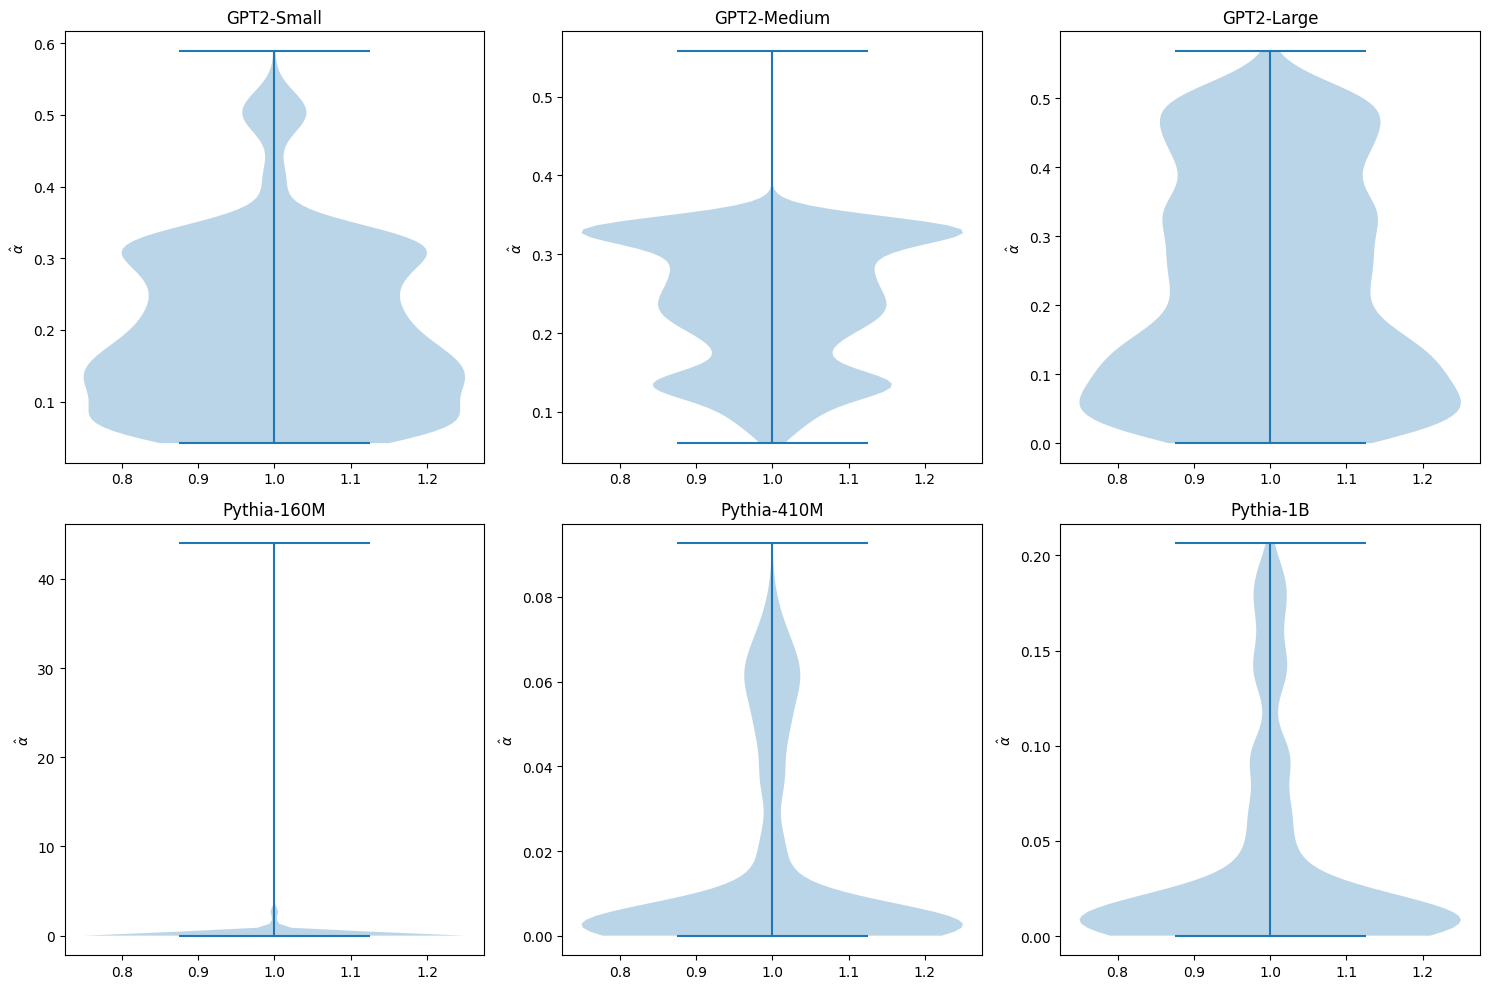

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Create boxplots
for ax, df, df_name in zip(axes_flat, dfs, df_names):
    ax.violinplot(df['exp_fit_integral'])
    ax.set_title(df_name)
    ax.set_ylabel(r'$\hat{\alpha}$')

plt.tight_layout()
plt.show()

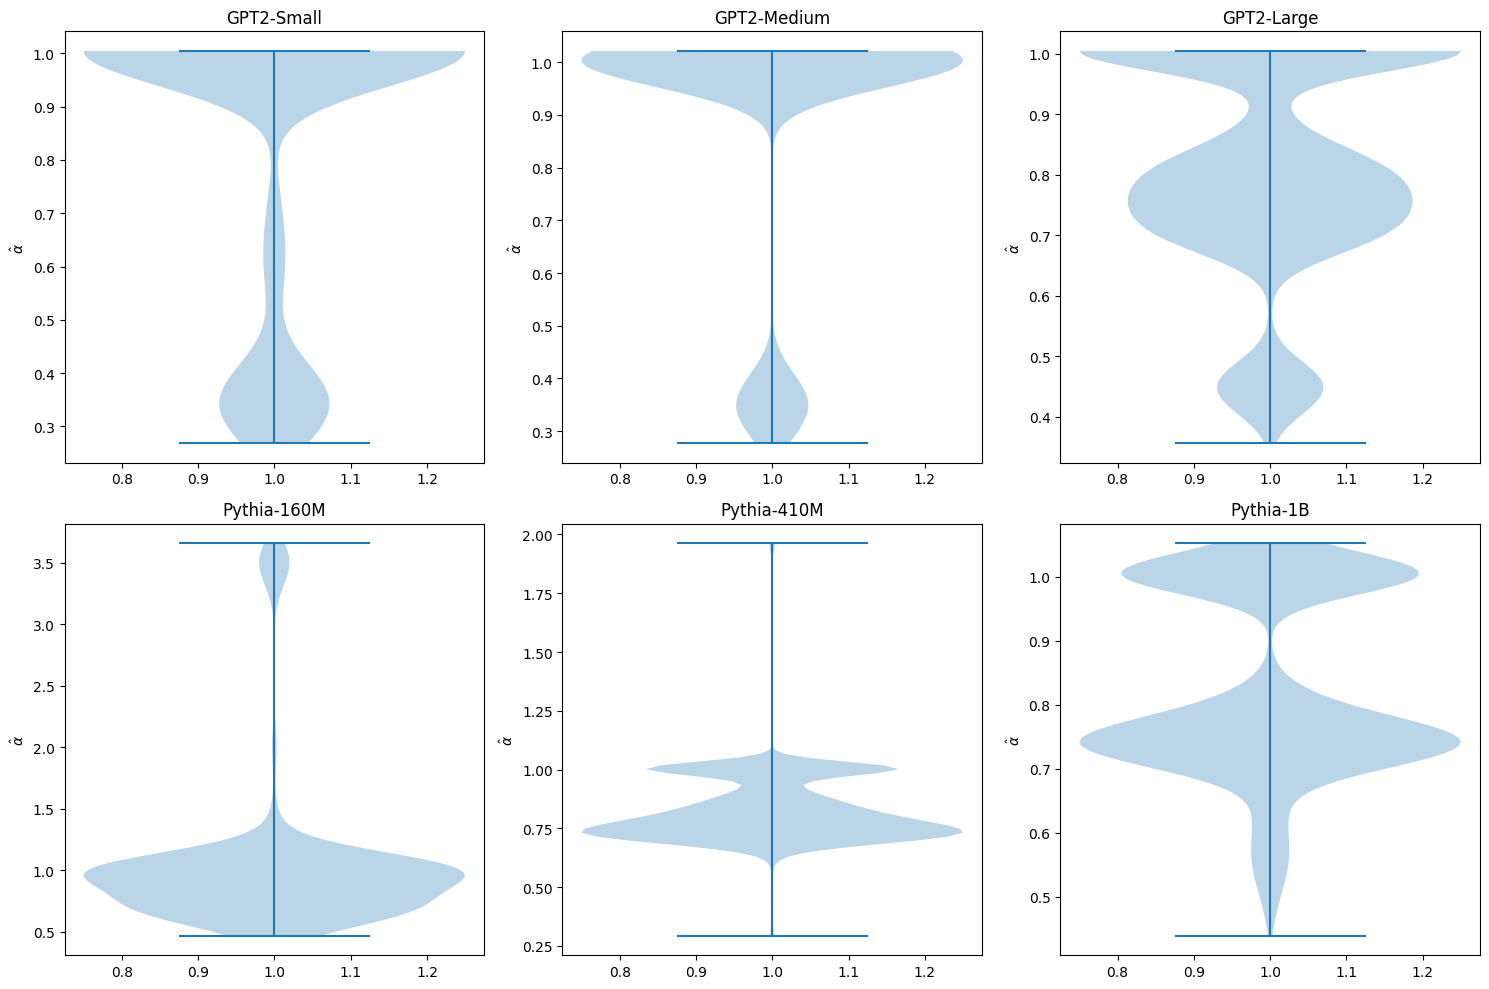

In [150]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Create boxplots
for ax, df, df_name in zip(axes_flat, dfs, df_names):
    ax.violinplot(df['alpha_hat'])
    ax.set_title(df_name)
    ax.set_ylabel(r'$\hat{\alpha}$')

plt.tight_layout()
plt.show()

In [ ]:
# Run some analyses
analyze_distribution_types(dfs, df_names)

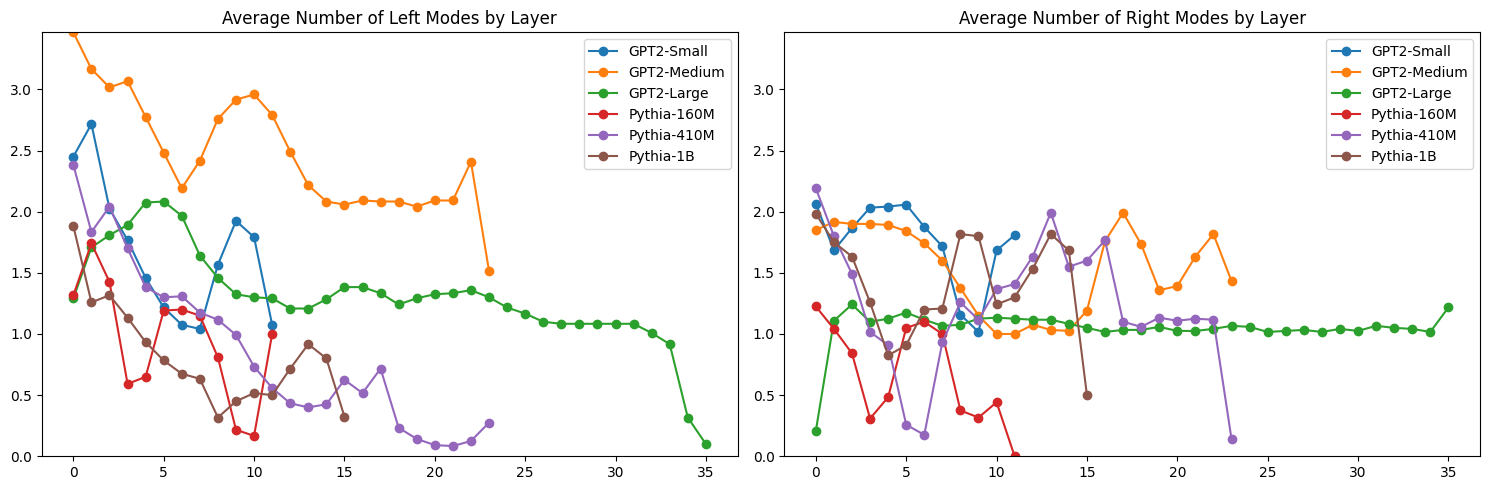

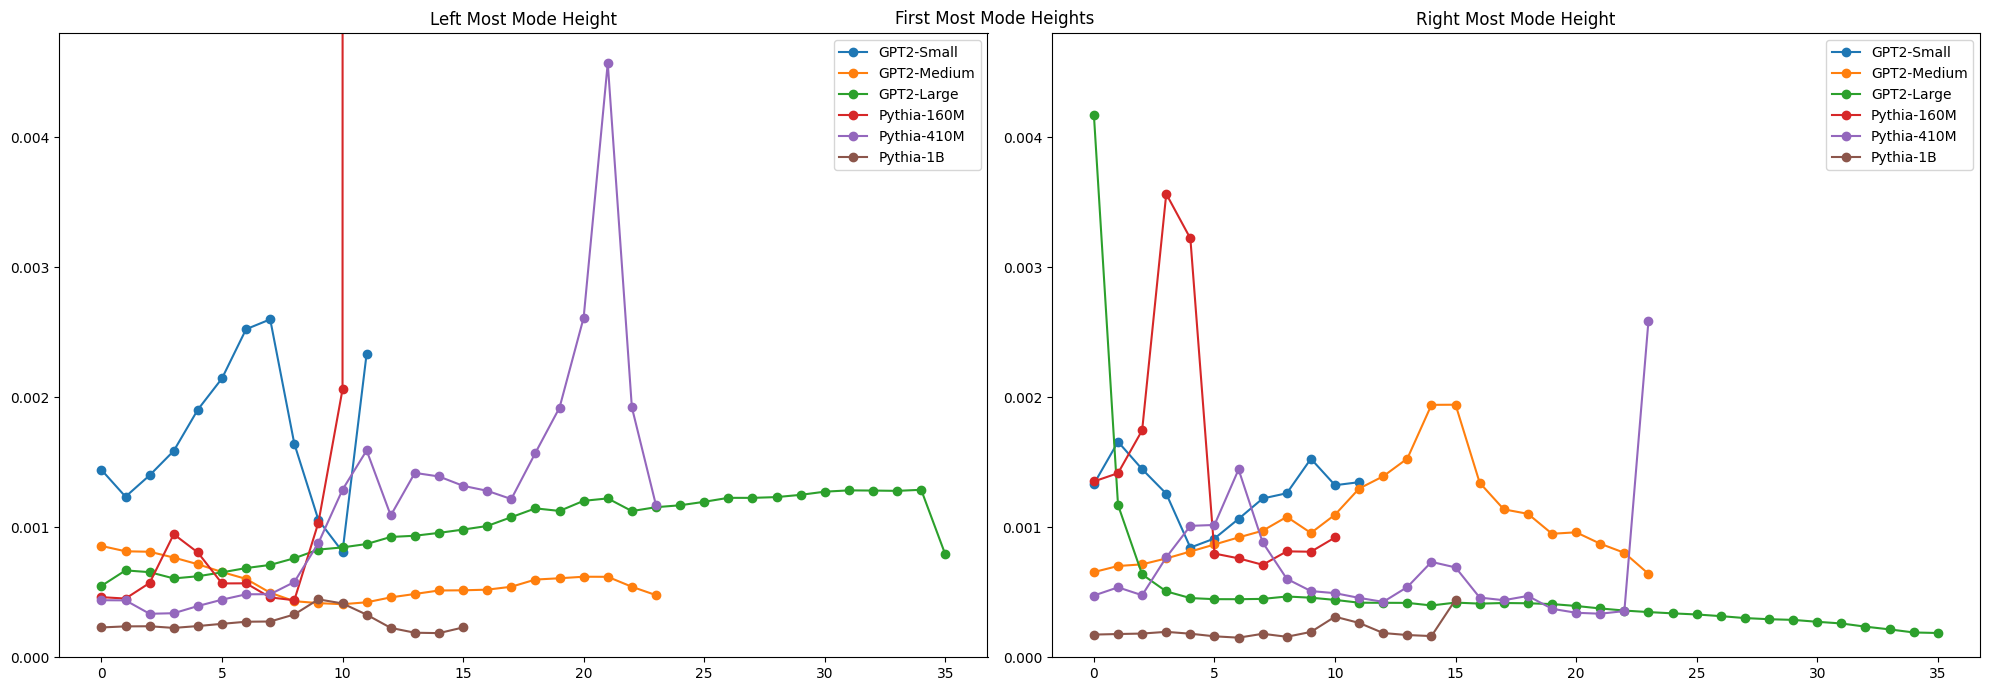

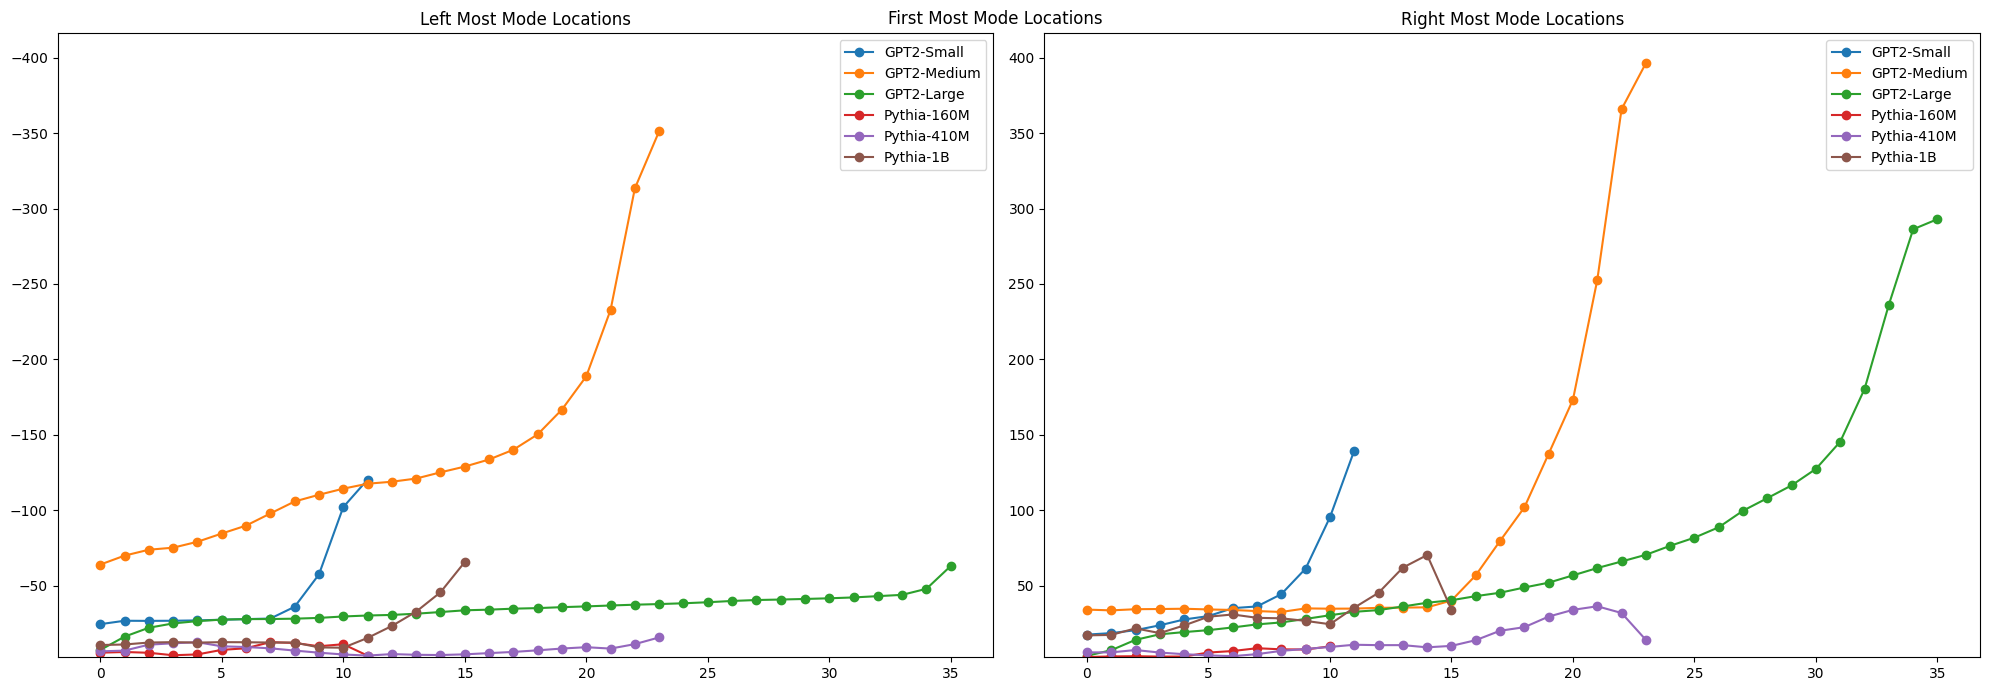

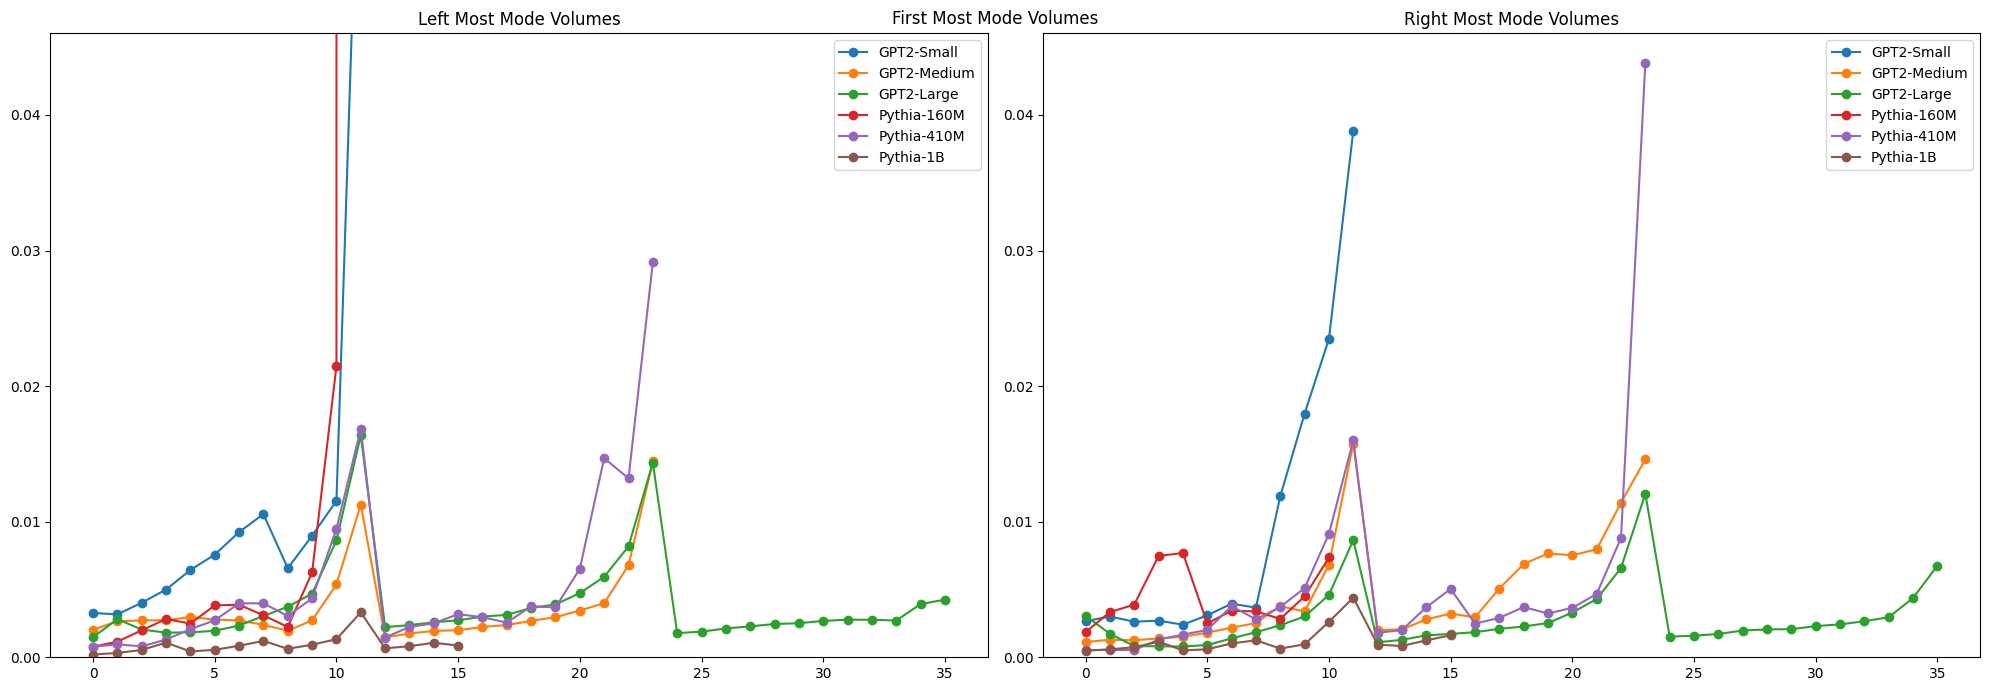

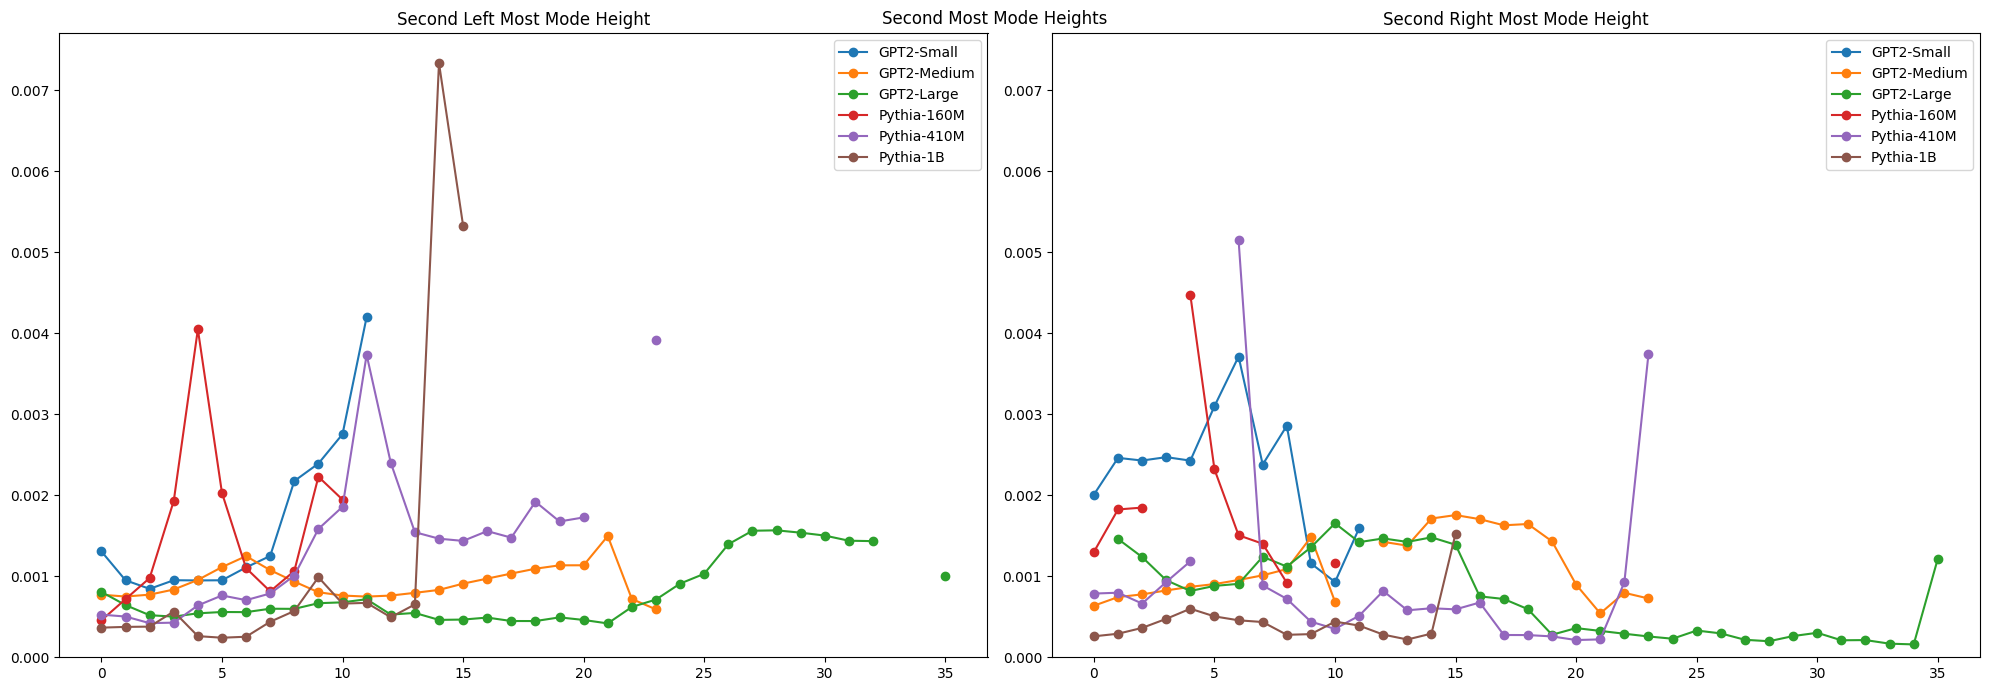

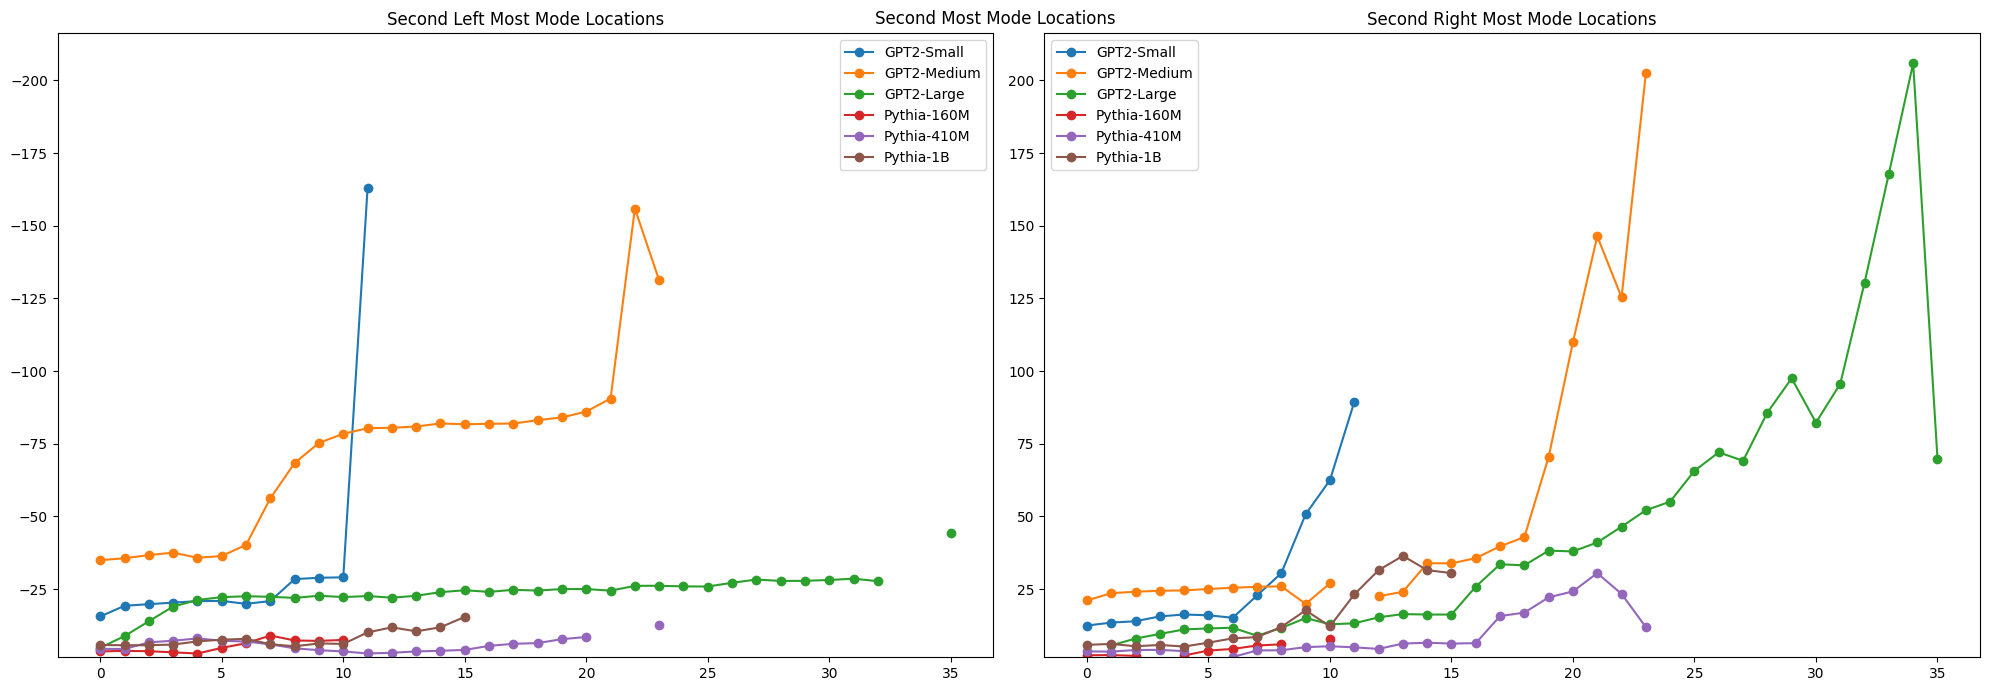

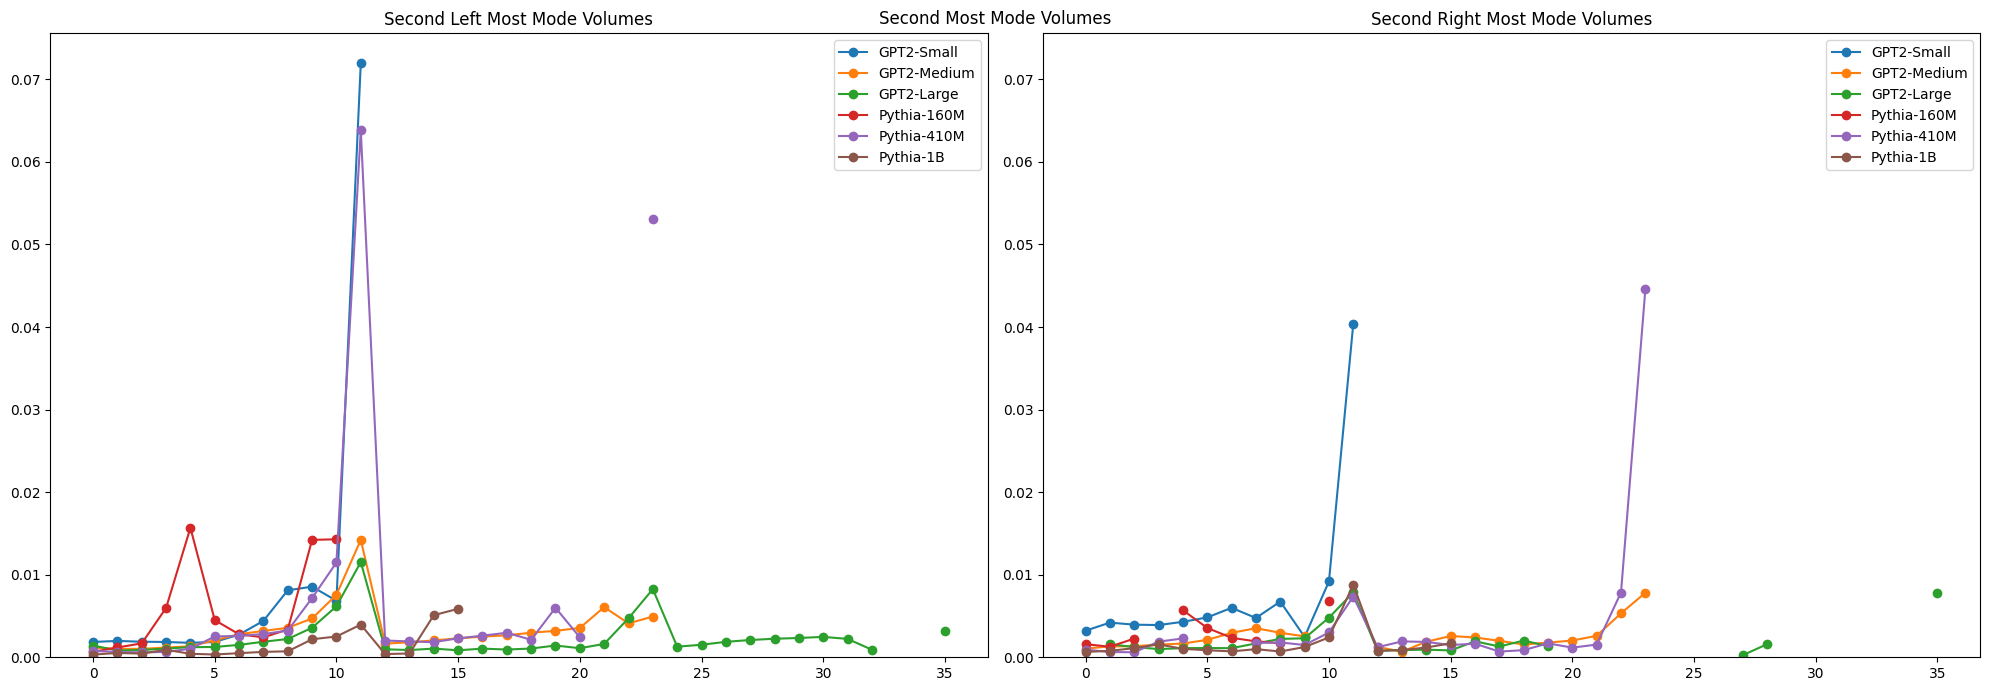

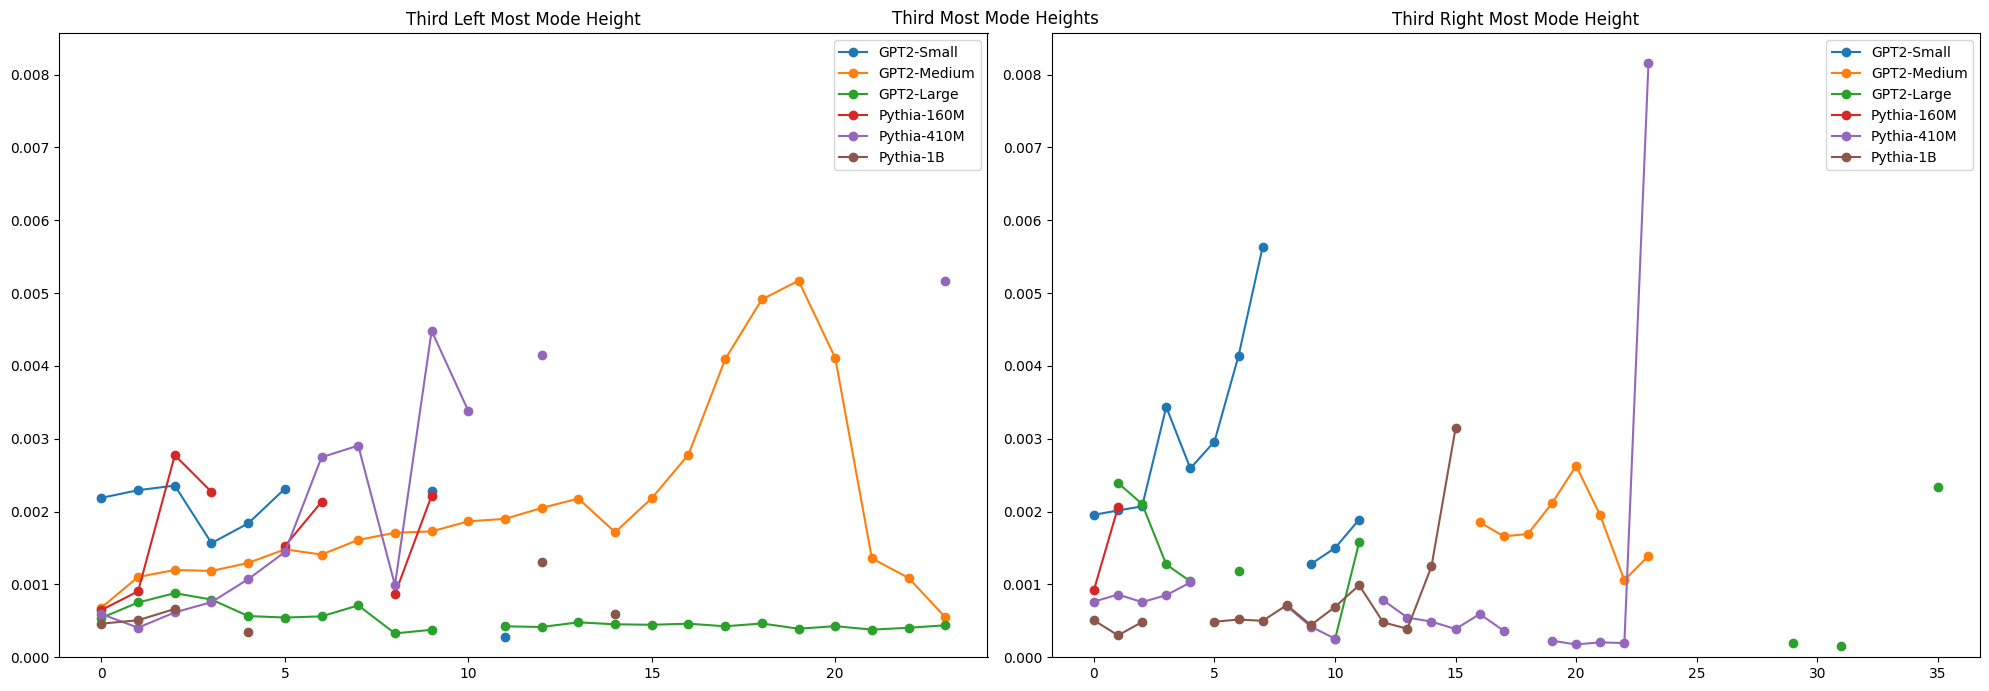

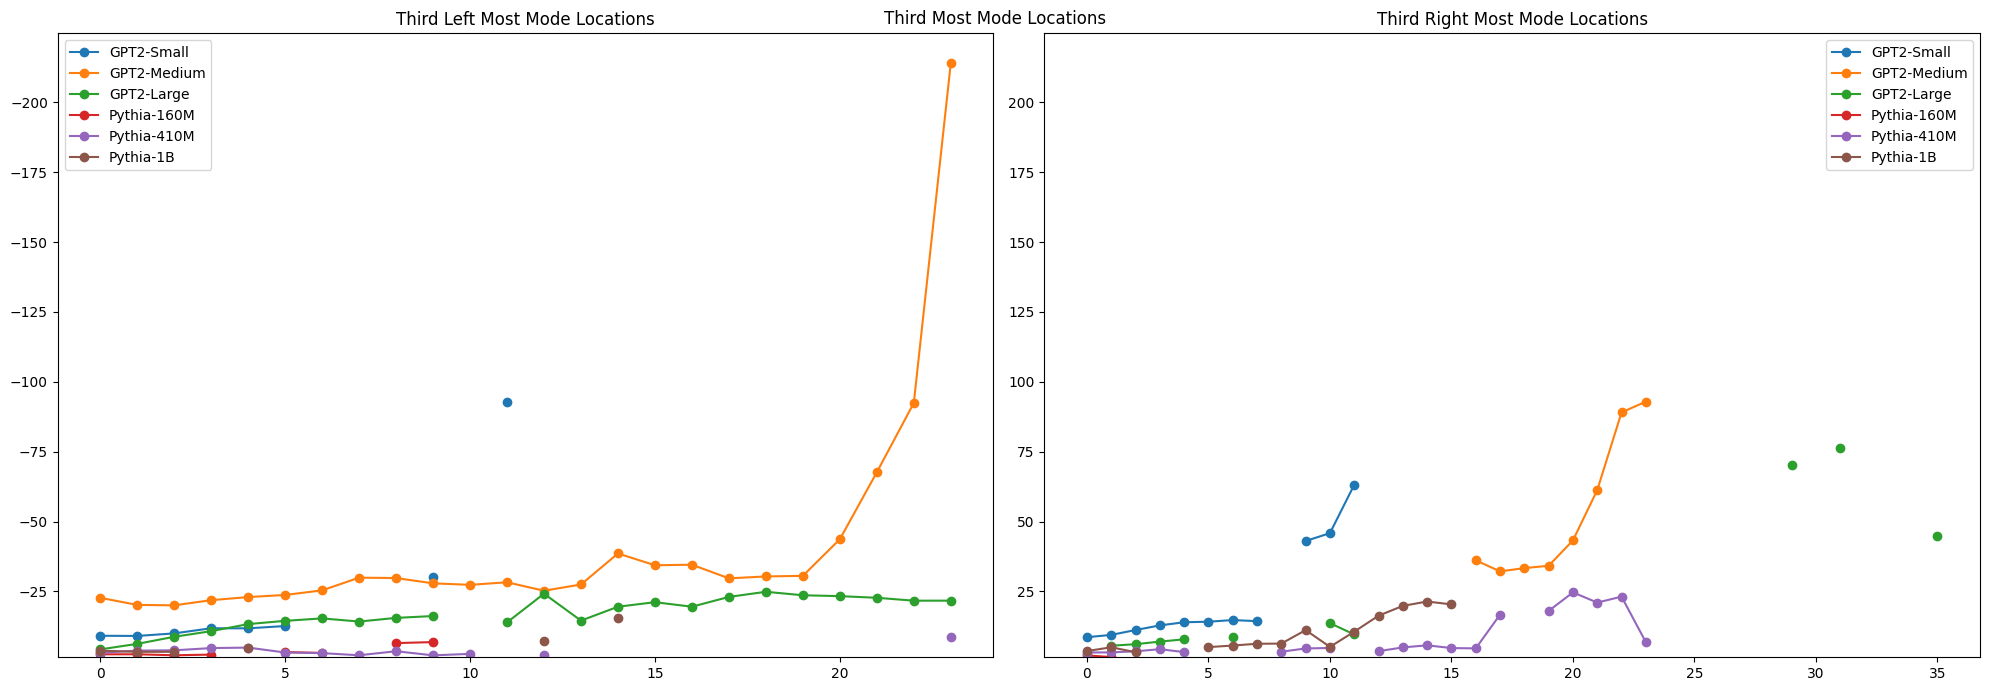

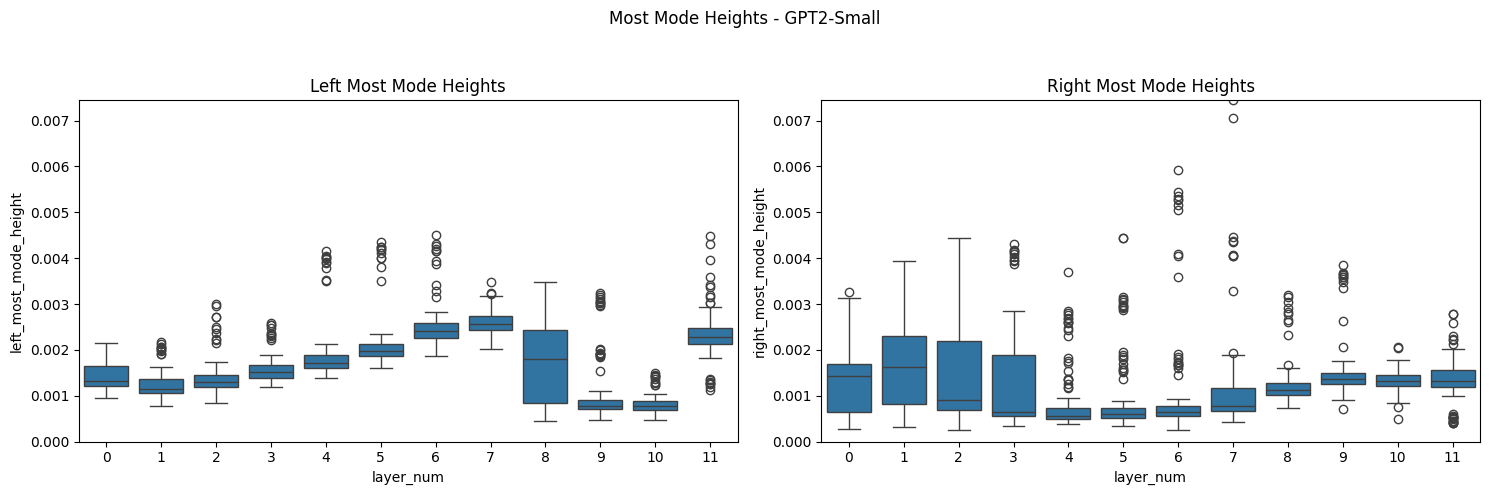

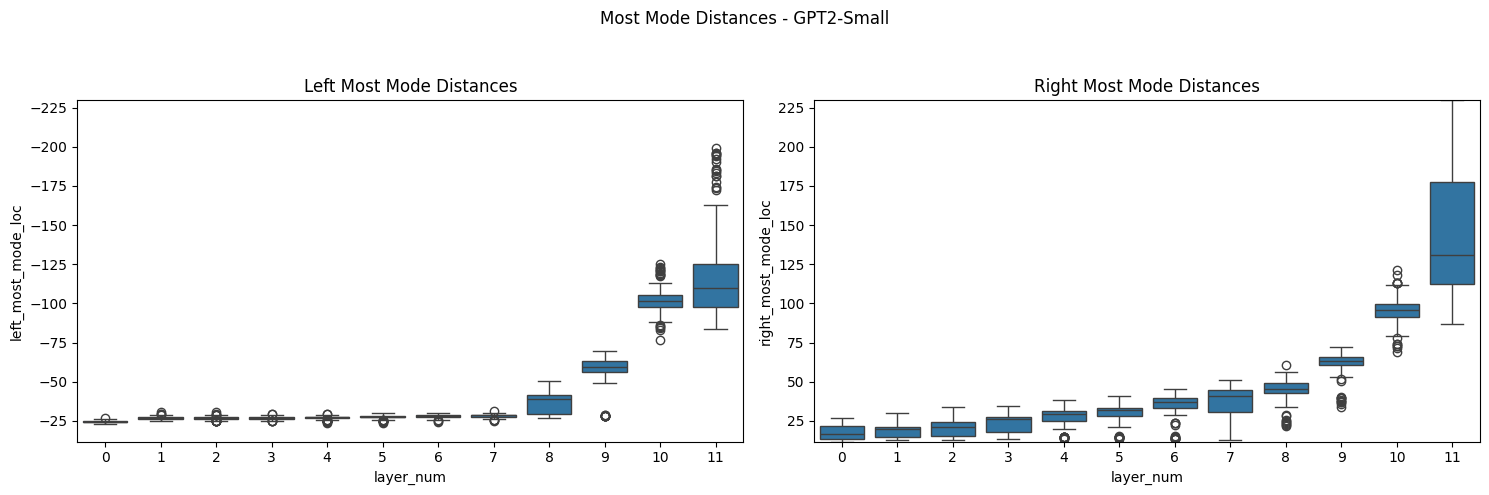

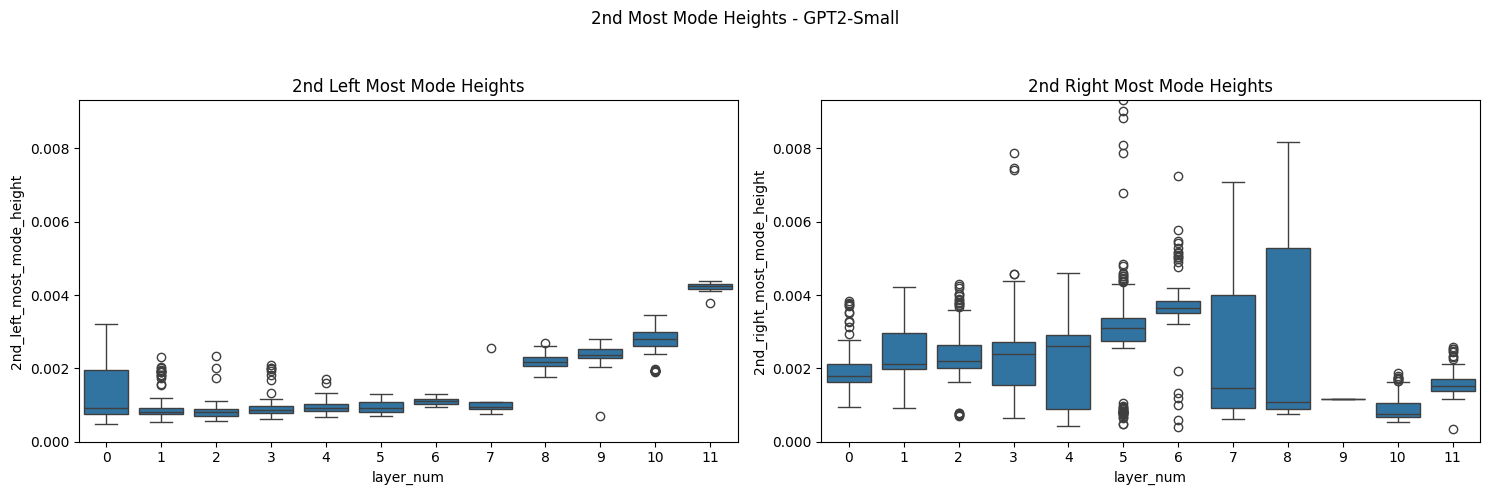

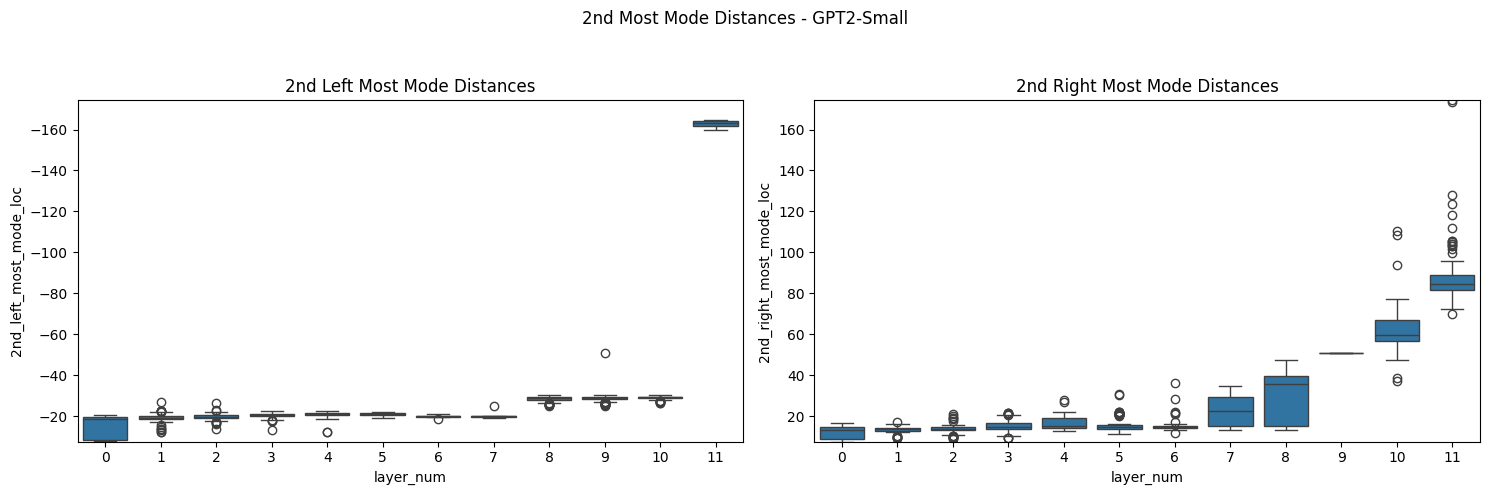

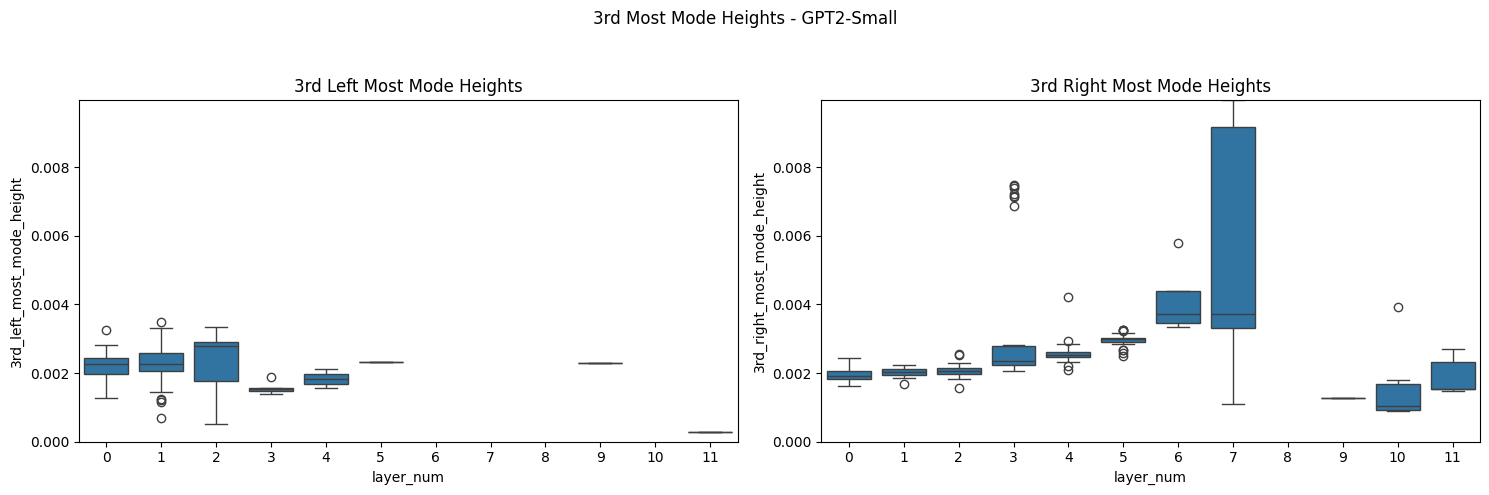

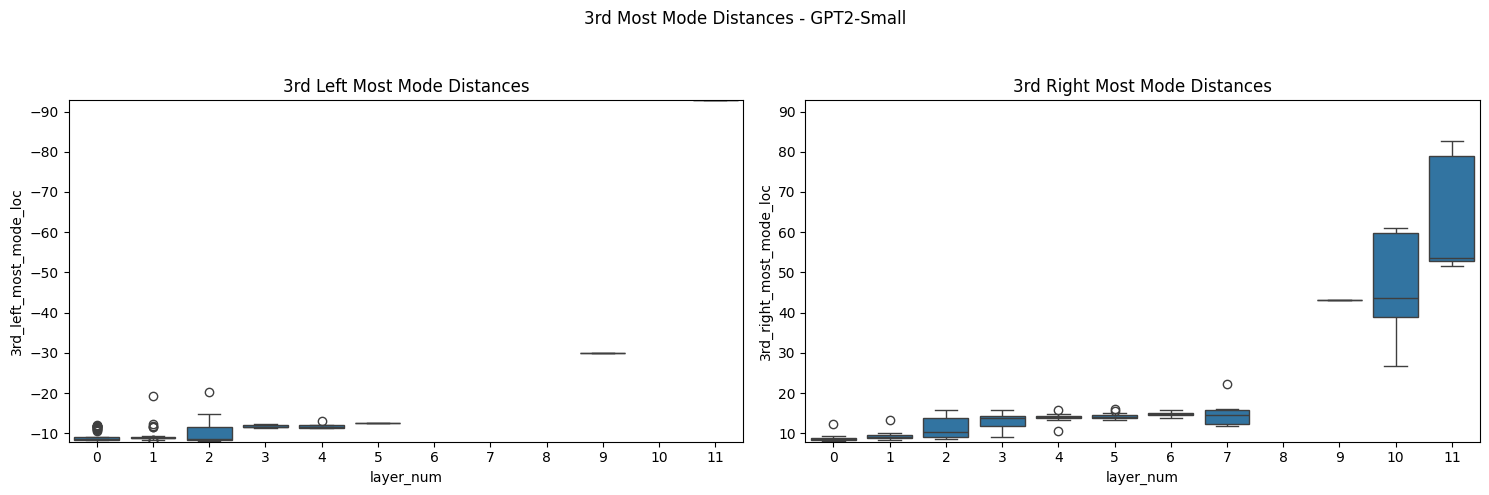

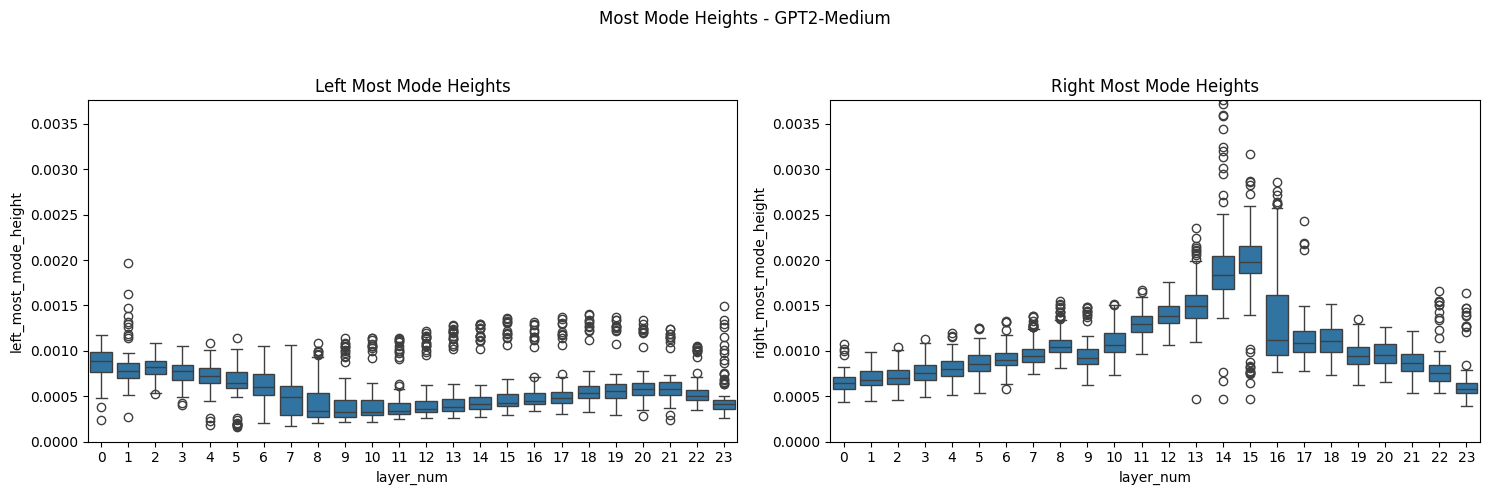

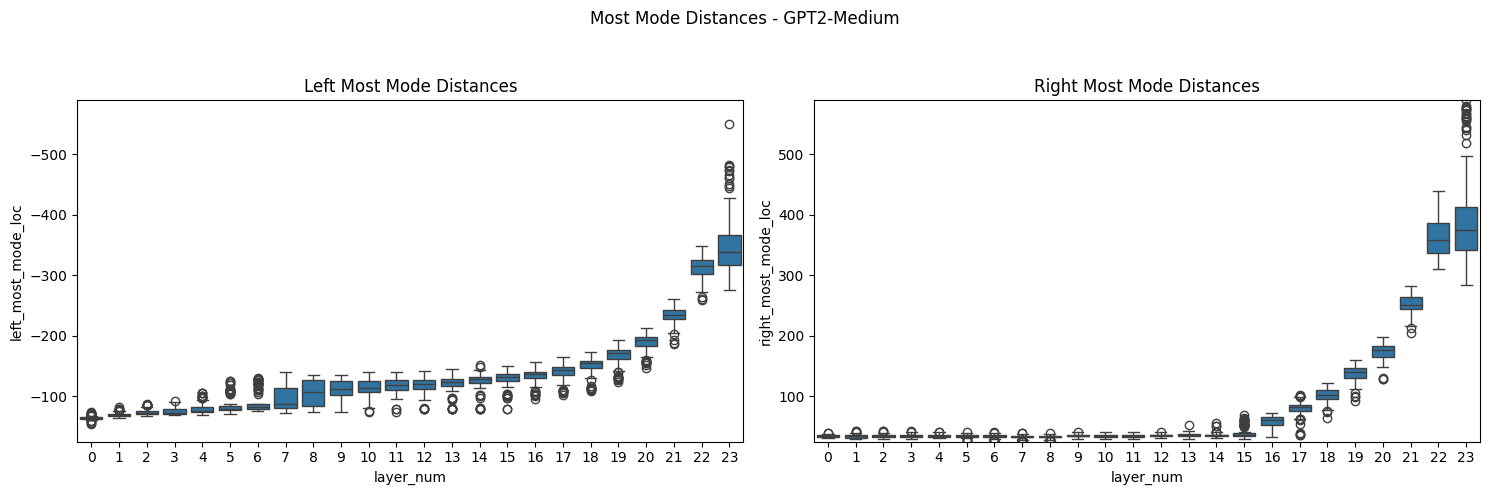

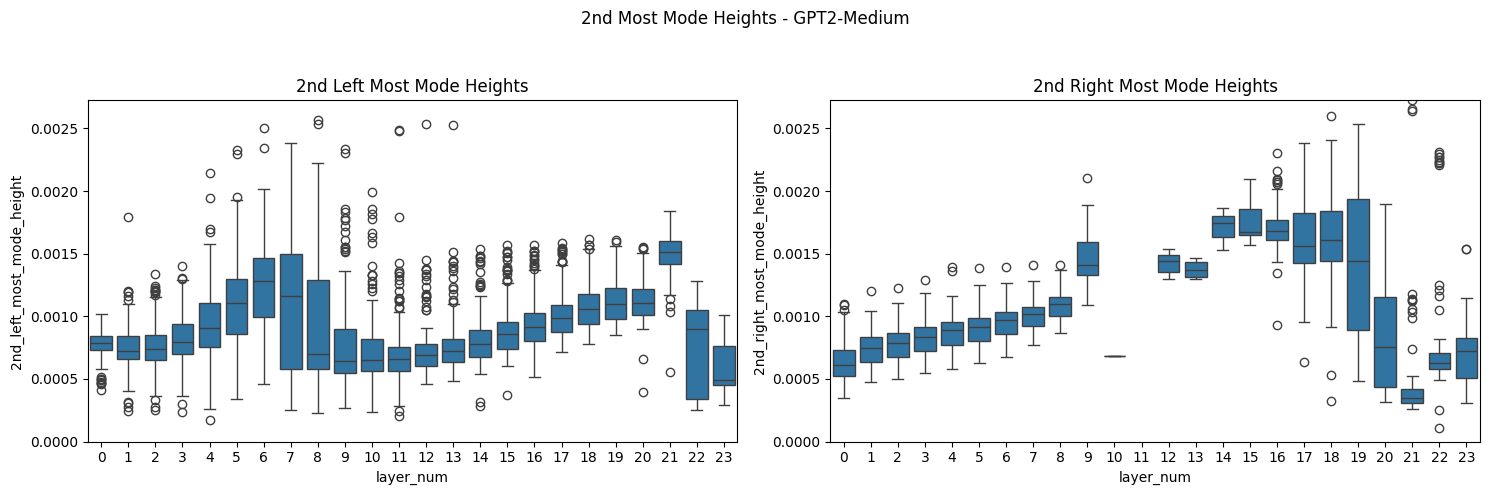

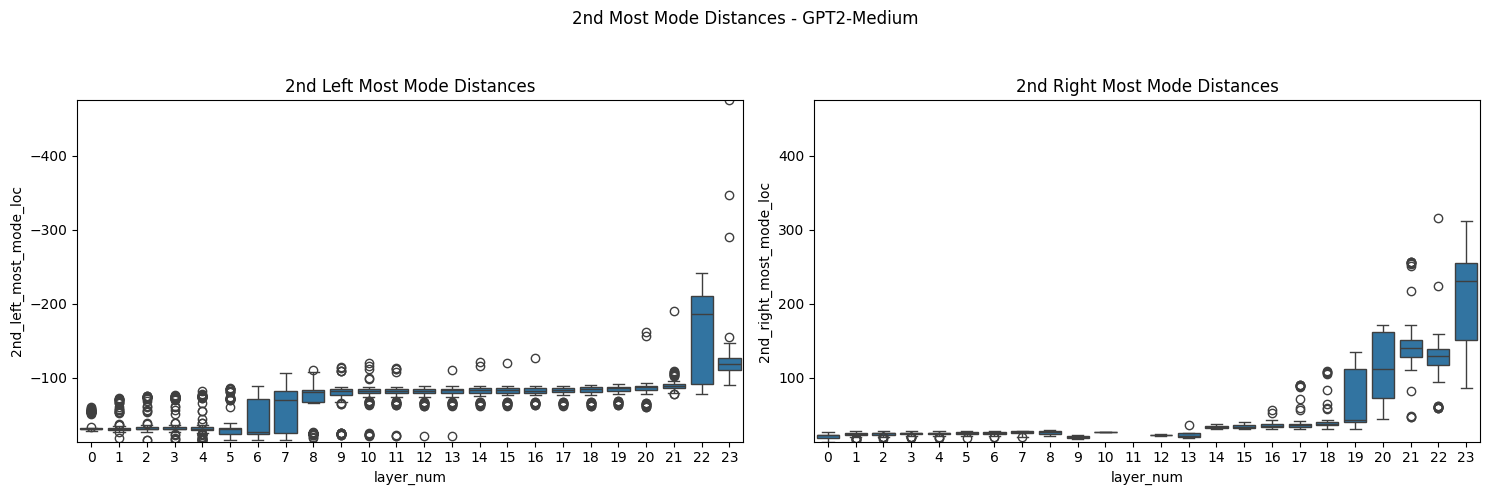

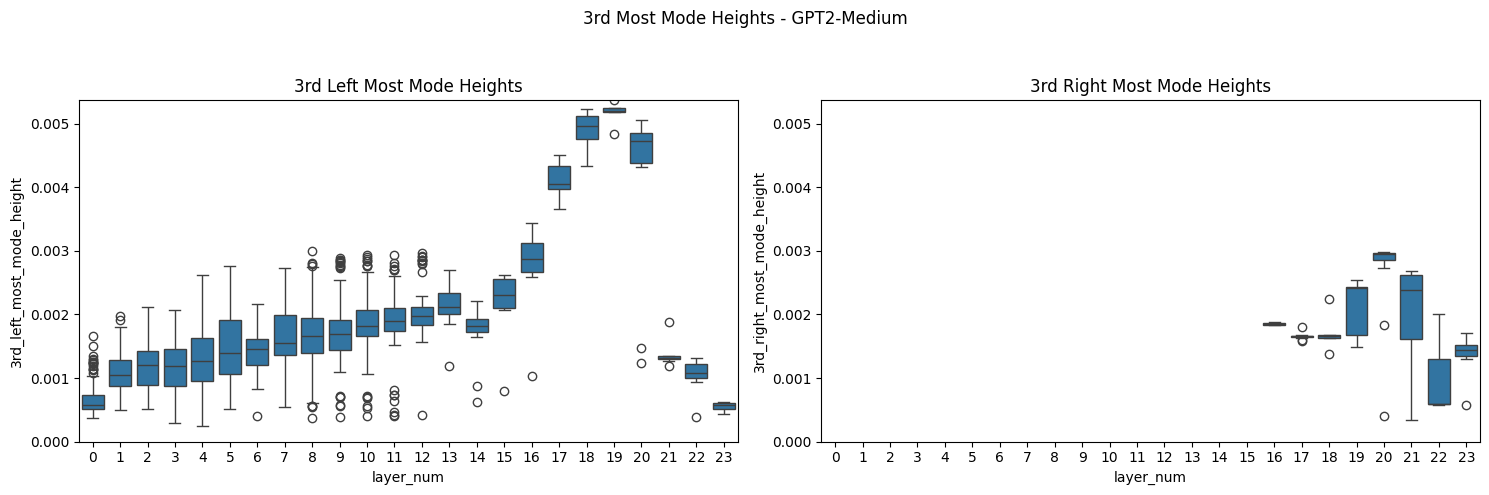

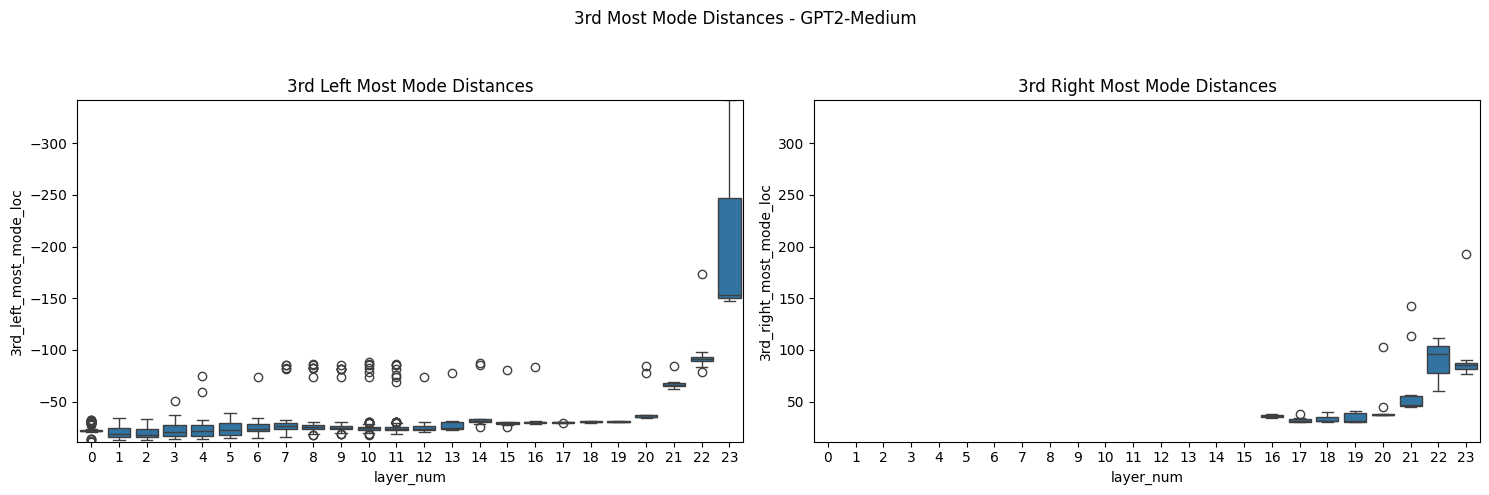

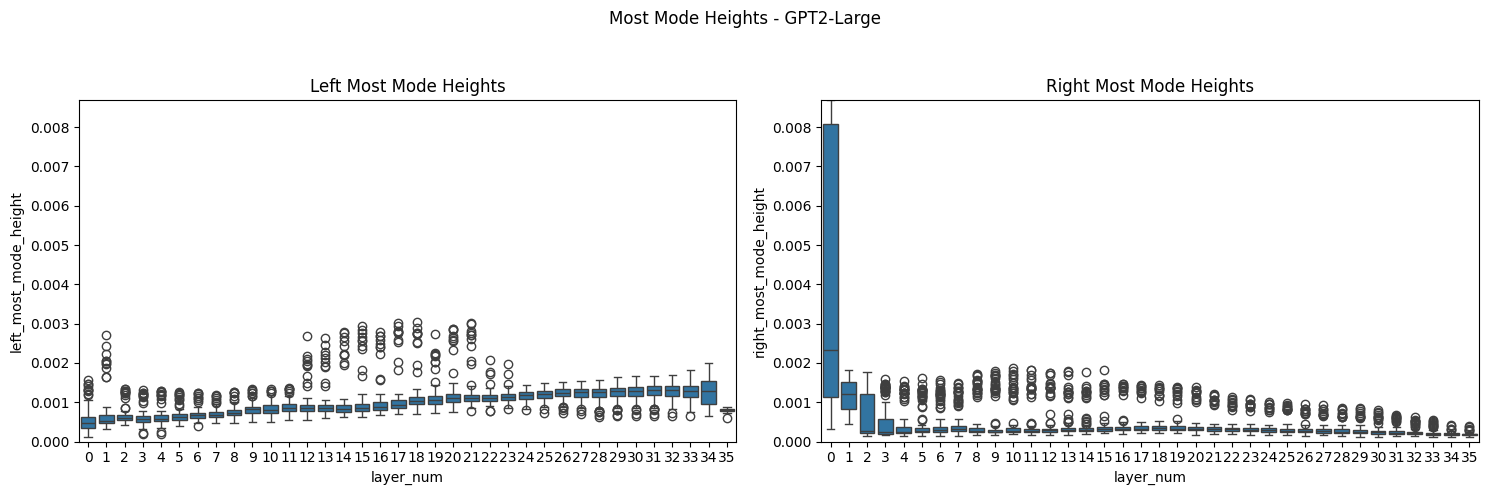

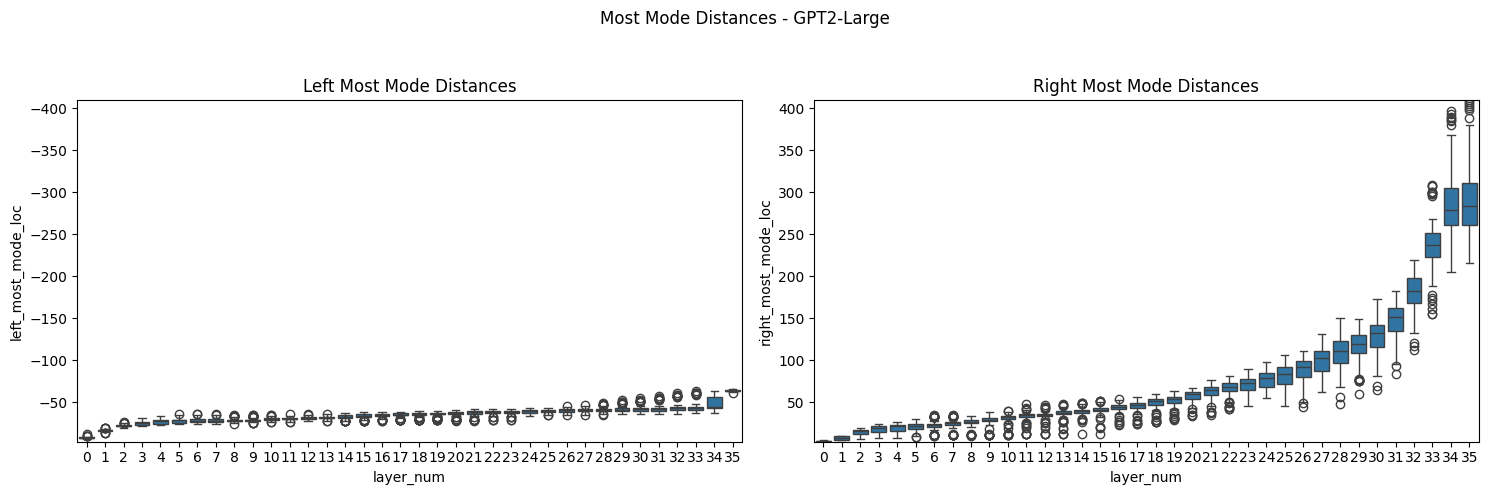

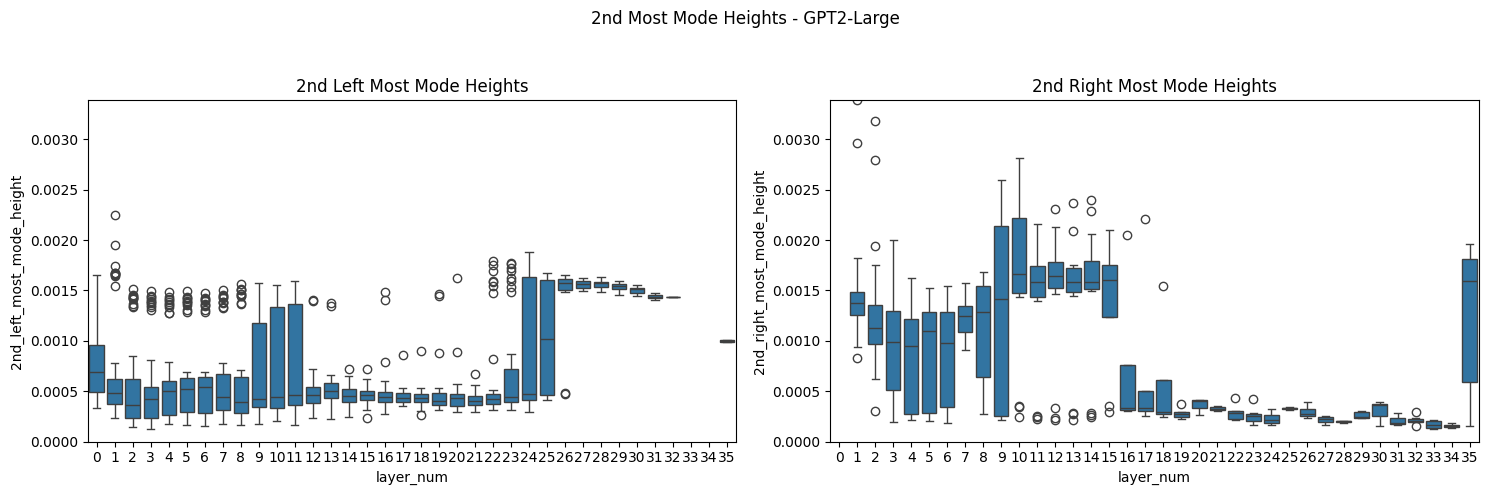

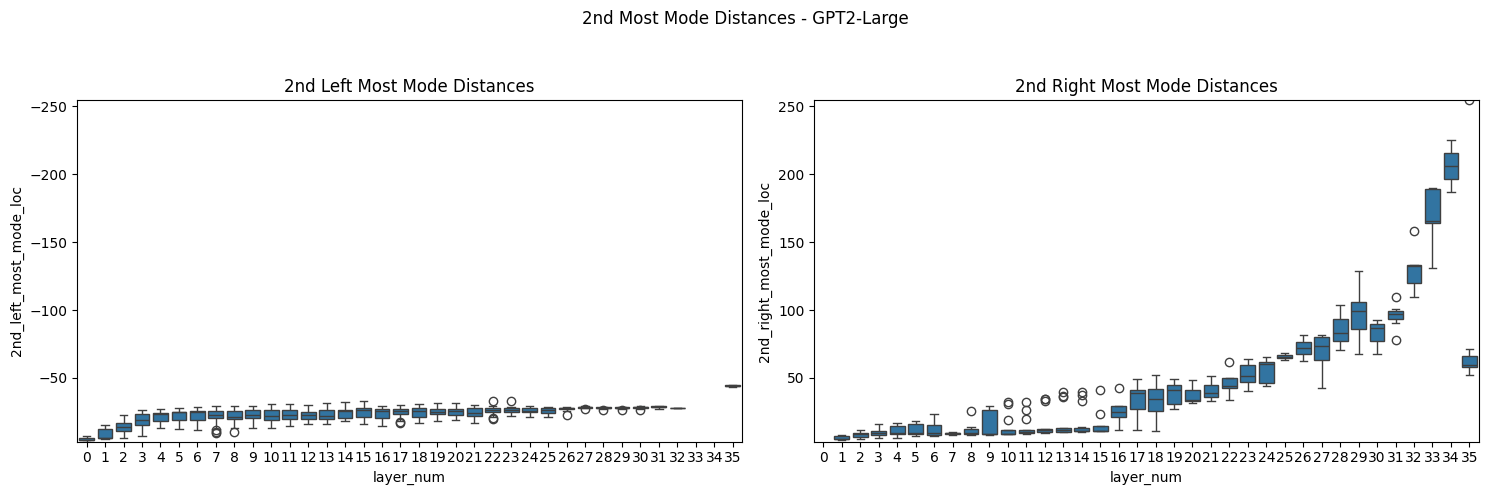

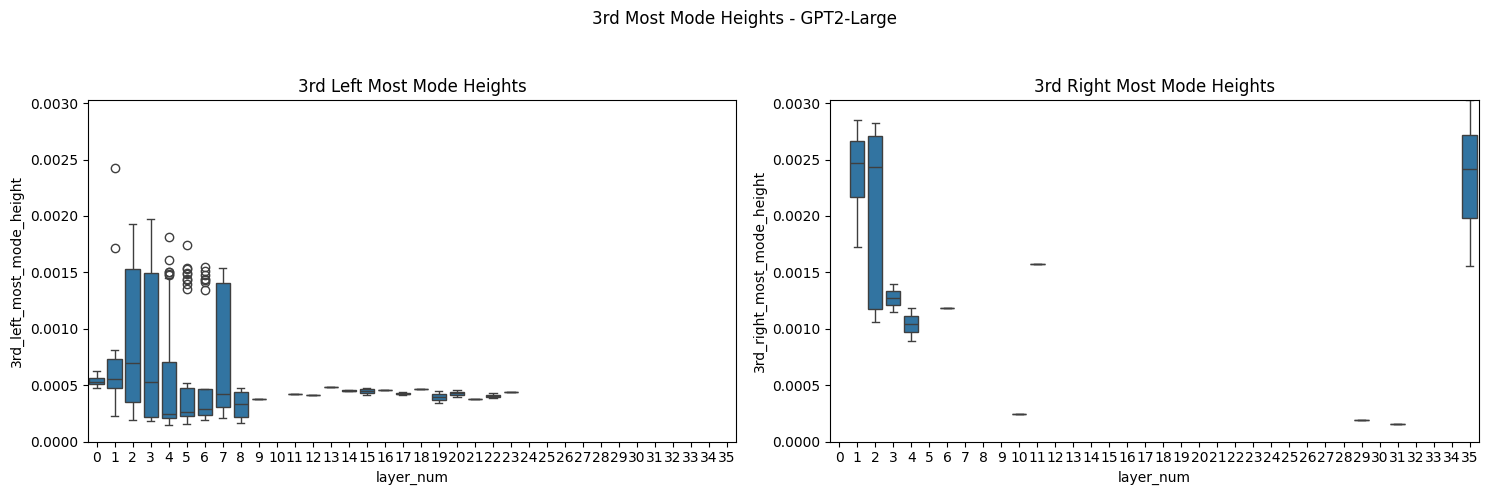

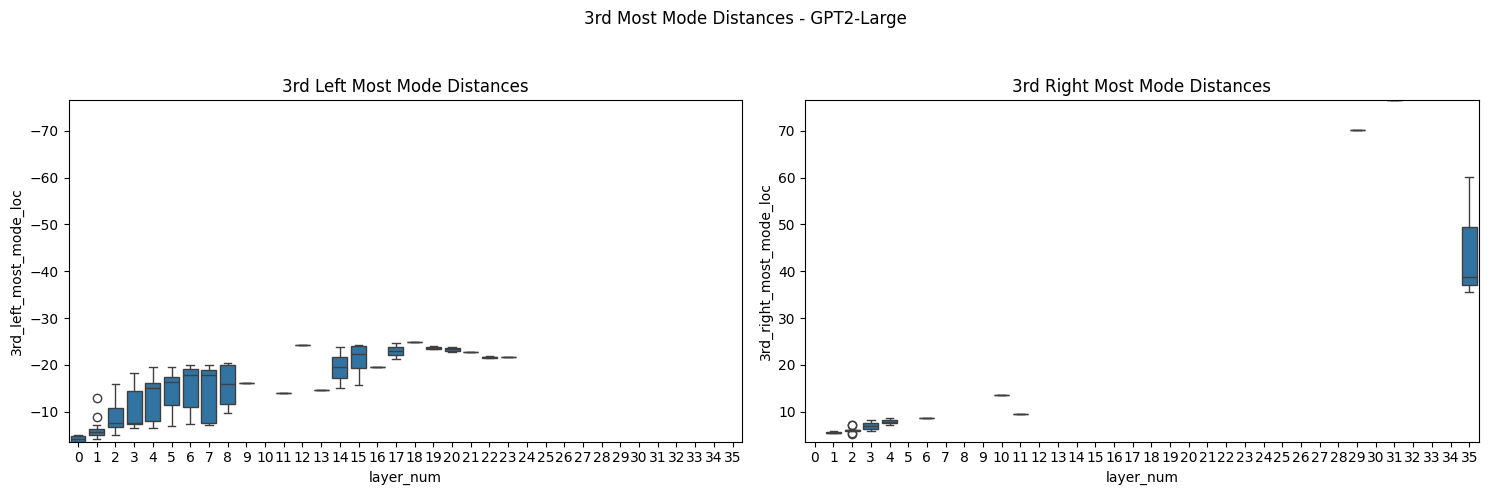

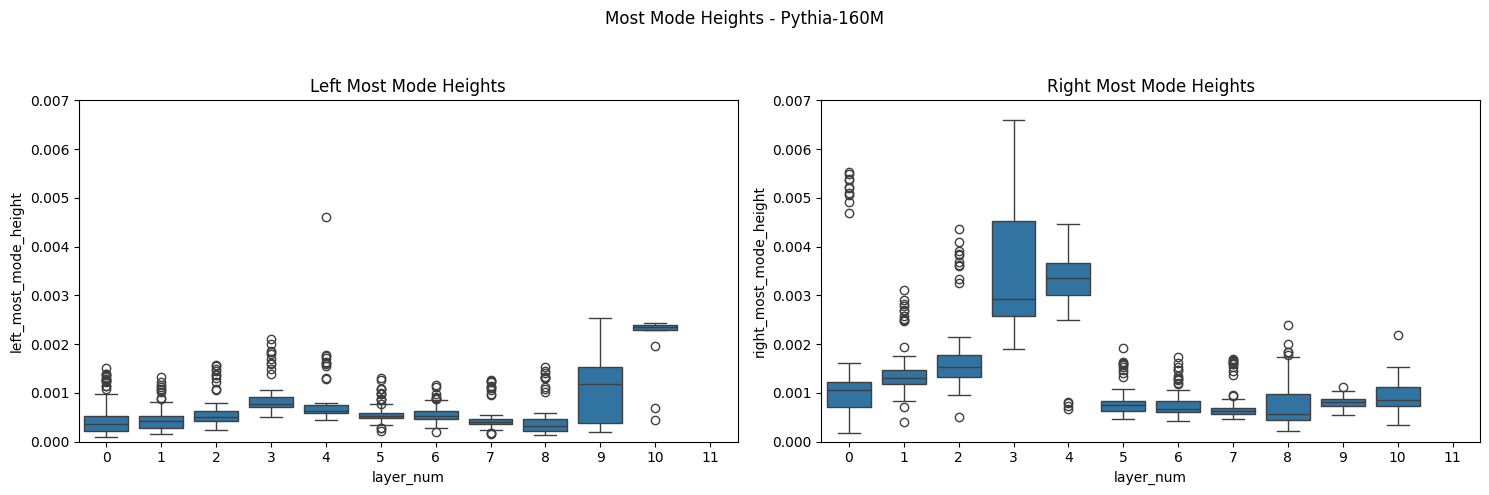

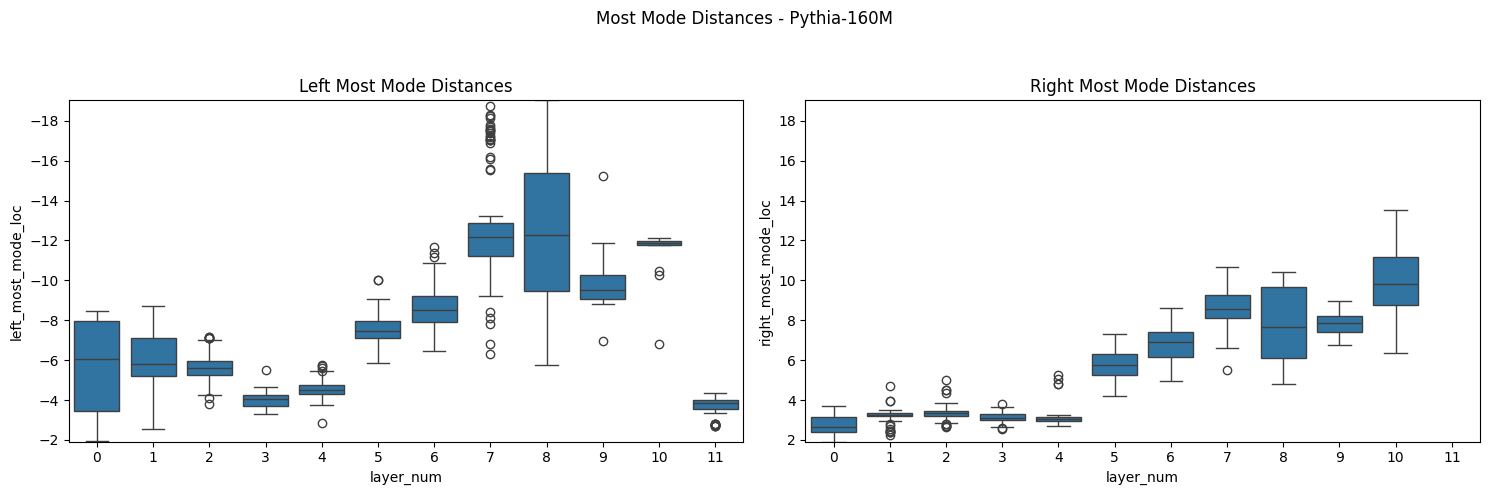

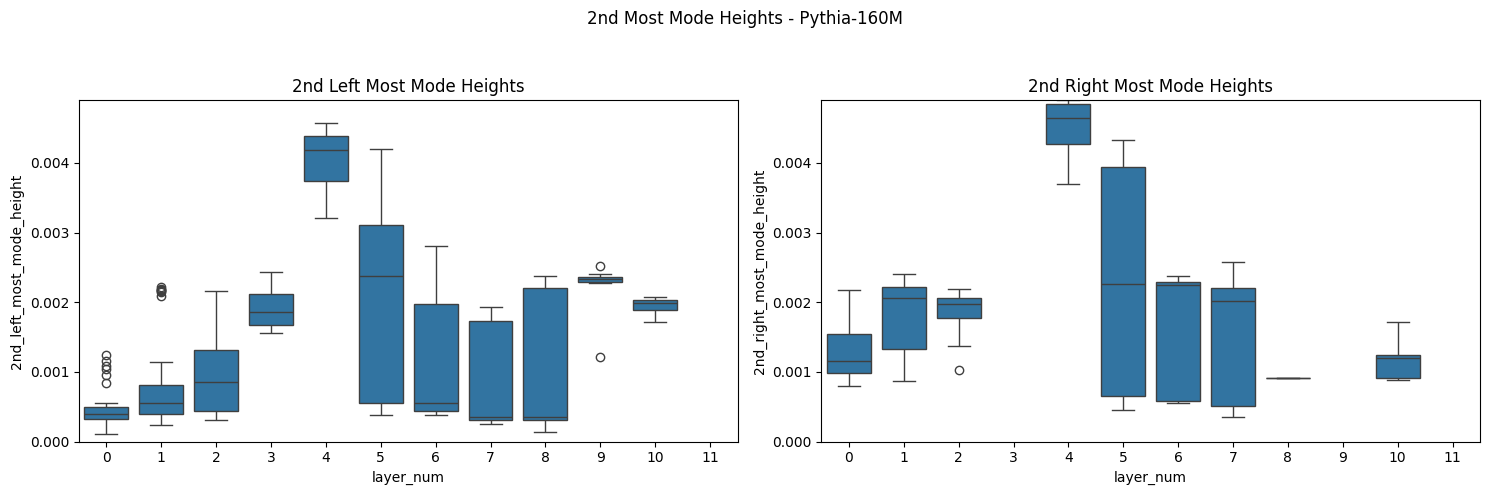

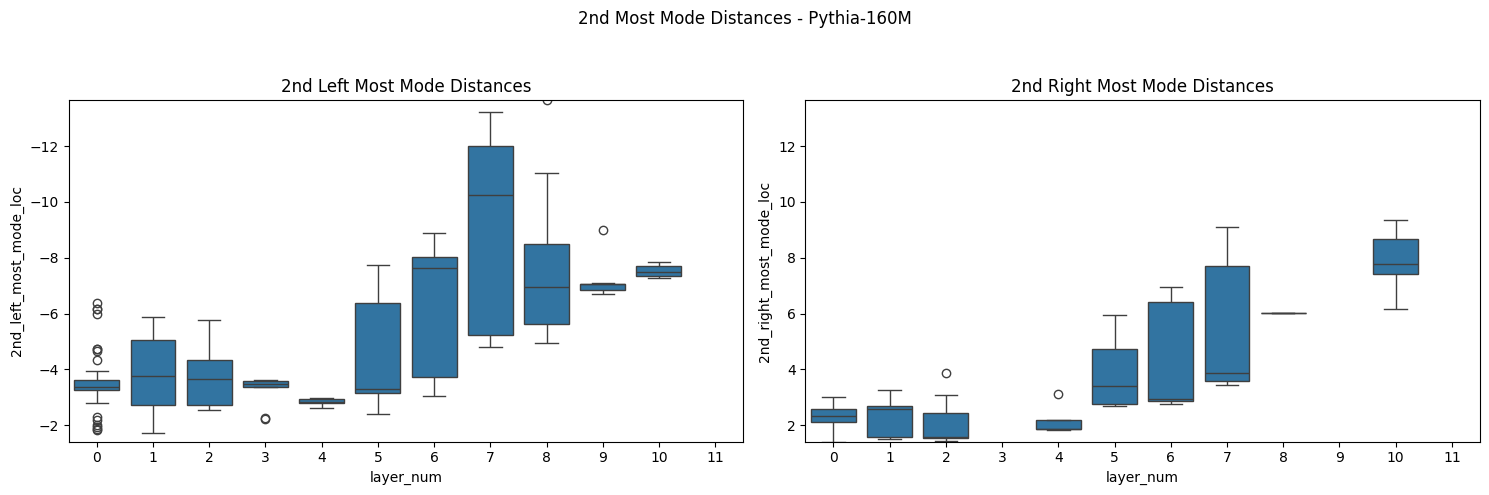

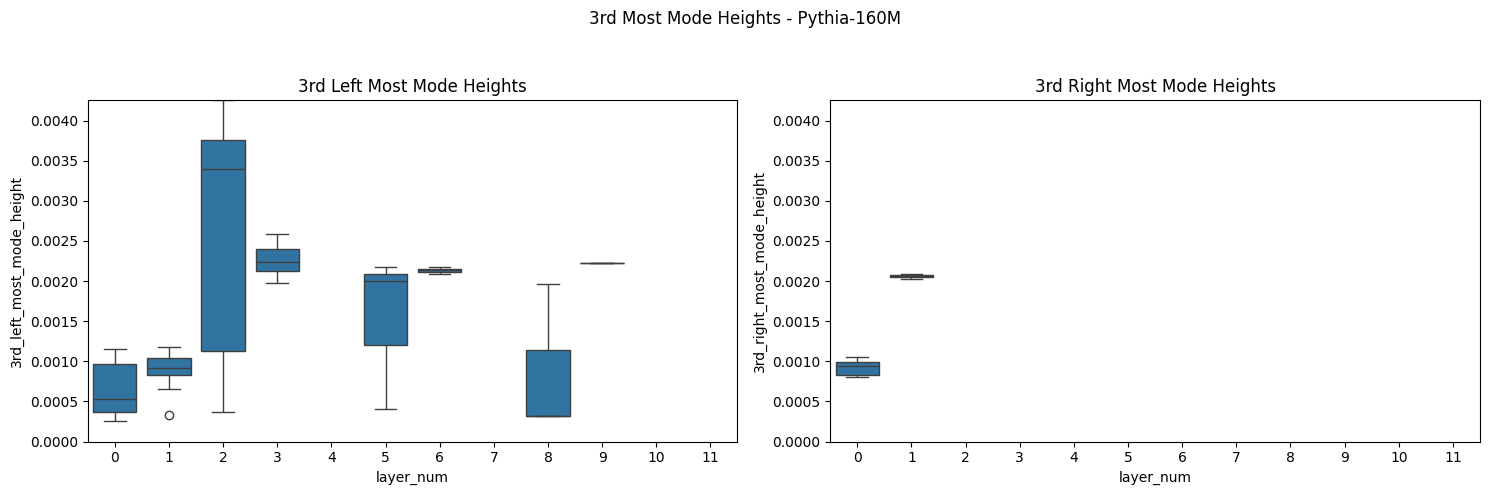

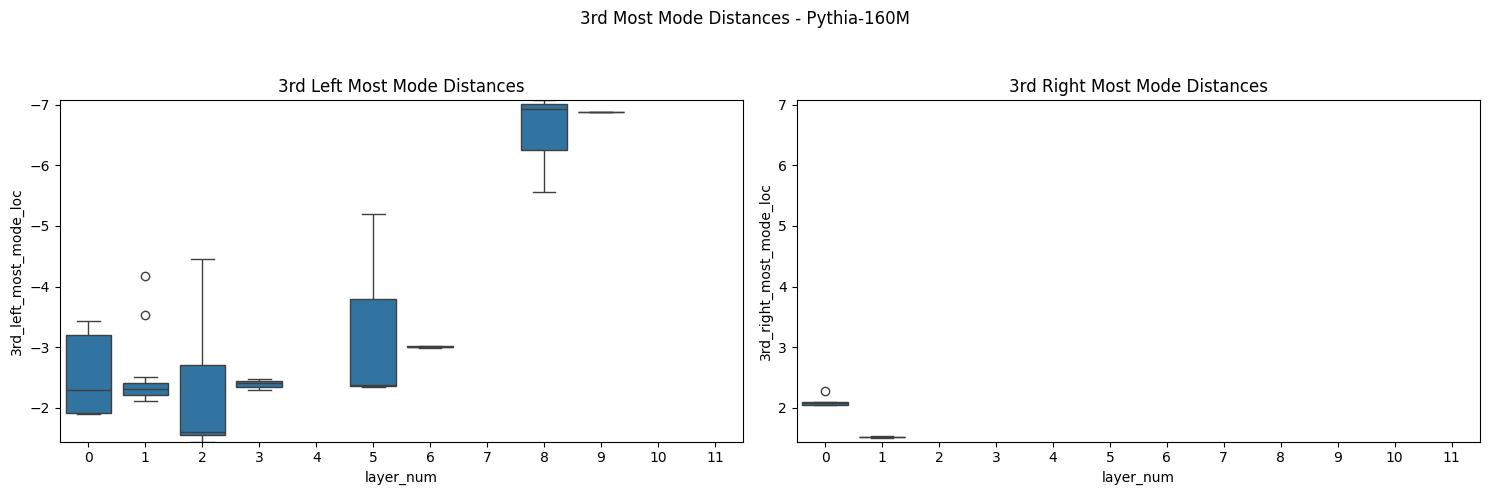

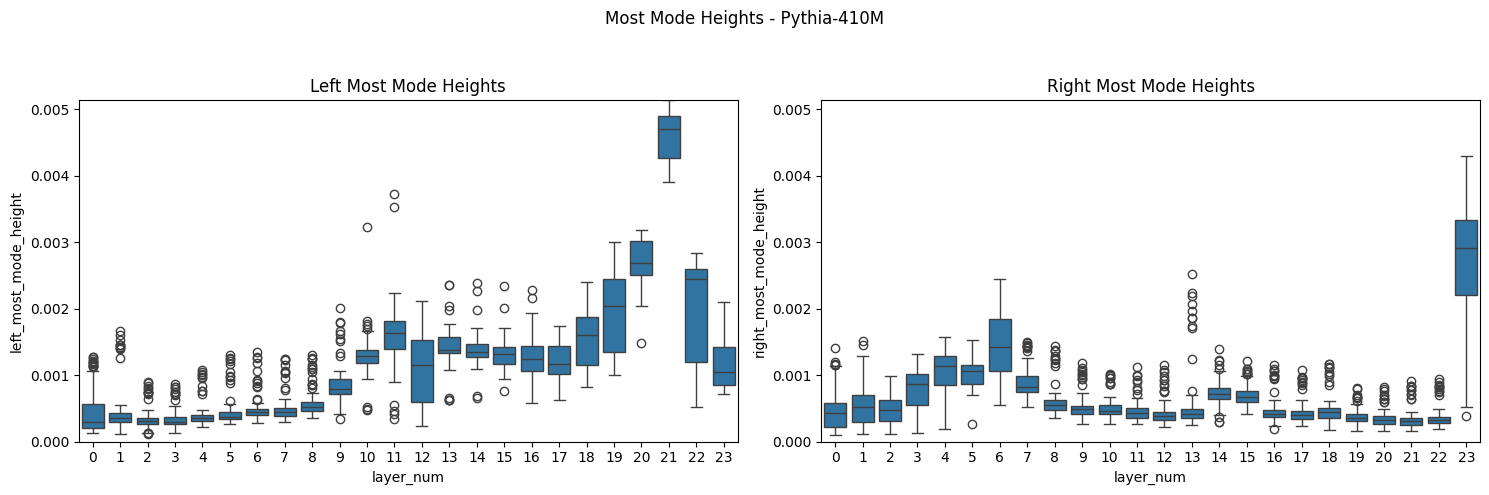

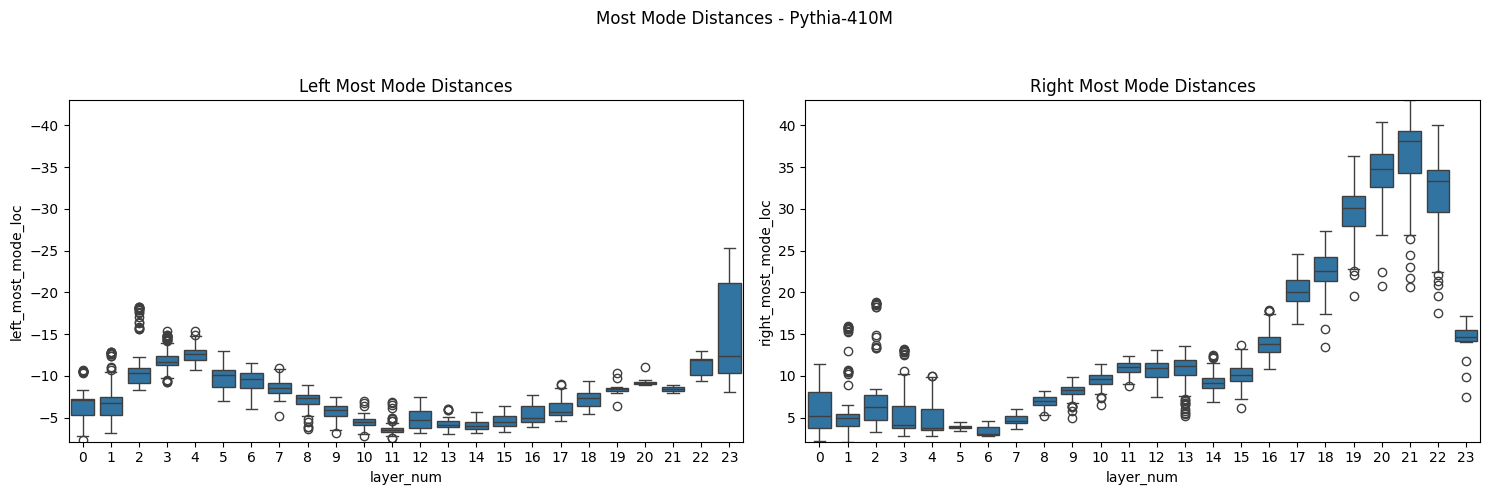

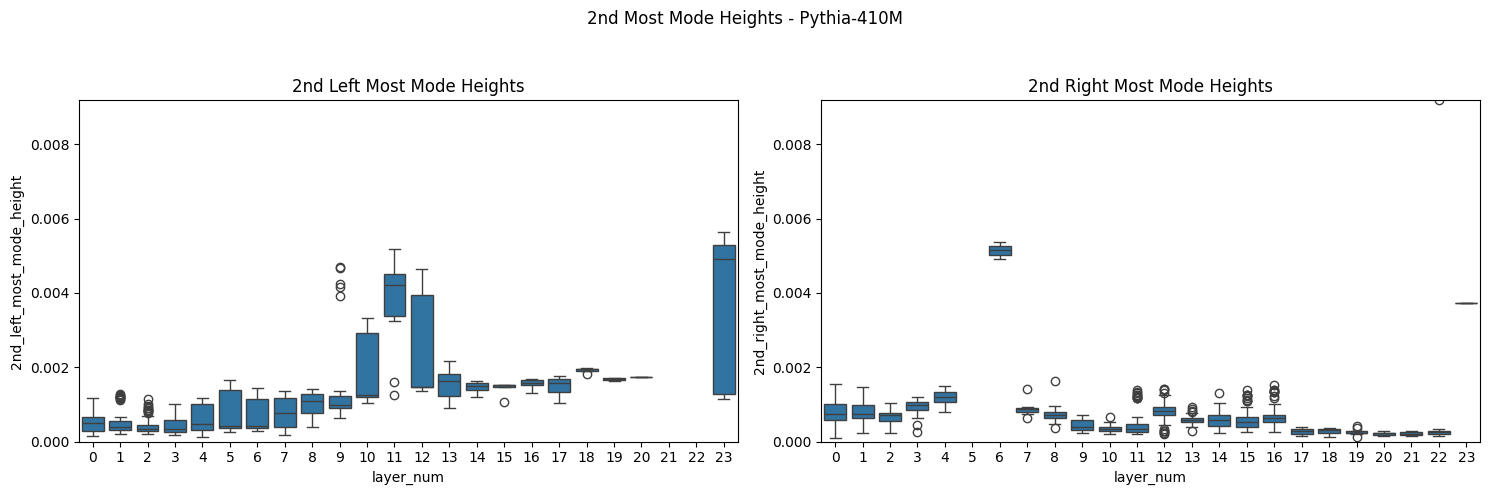

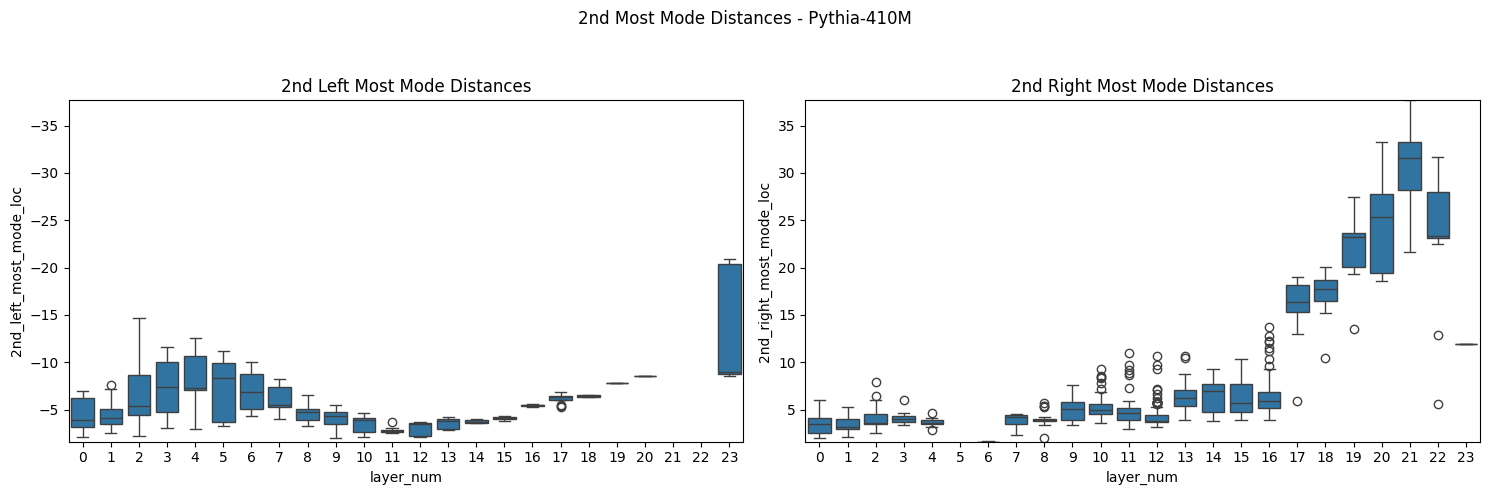

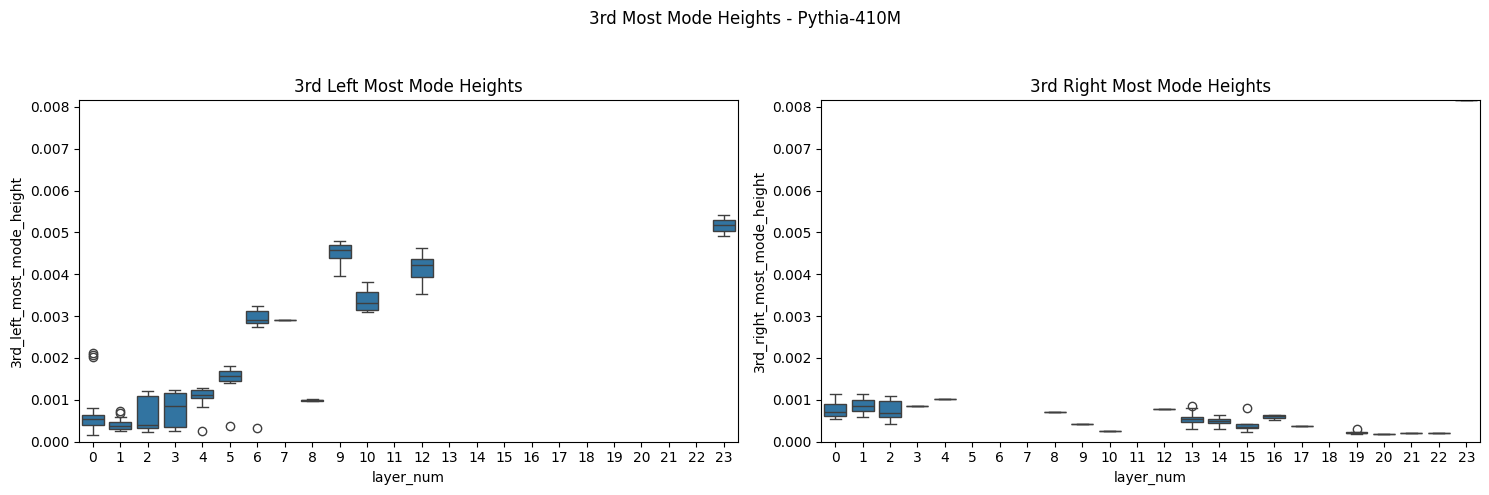

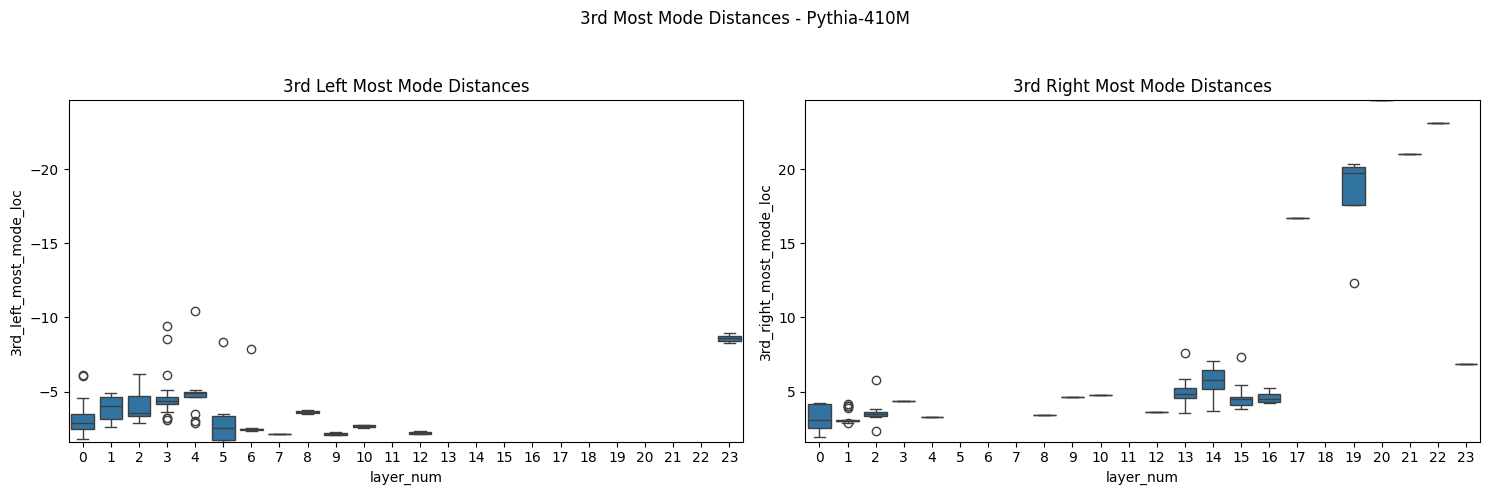

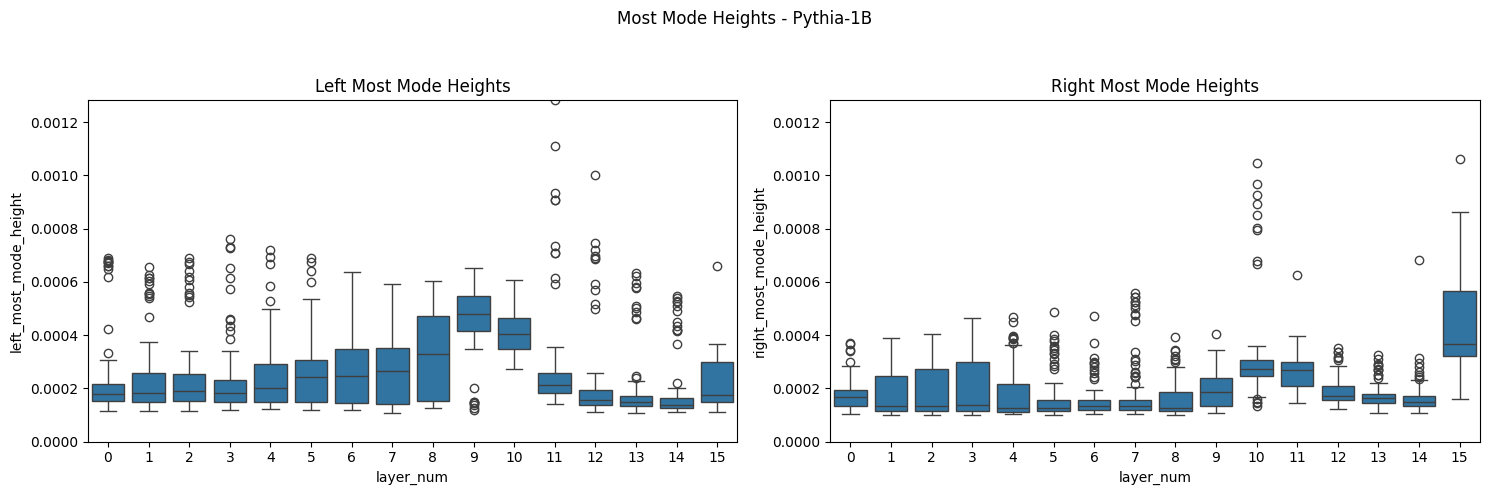

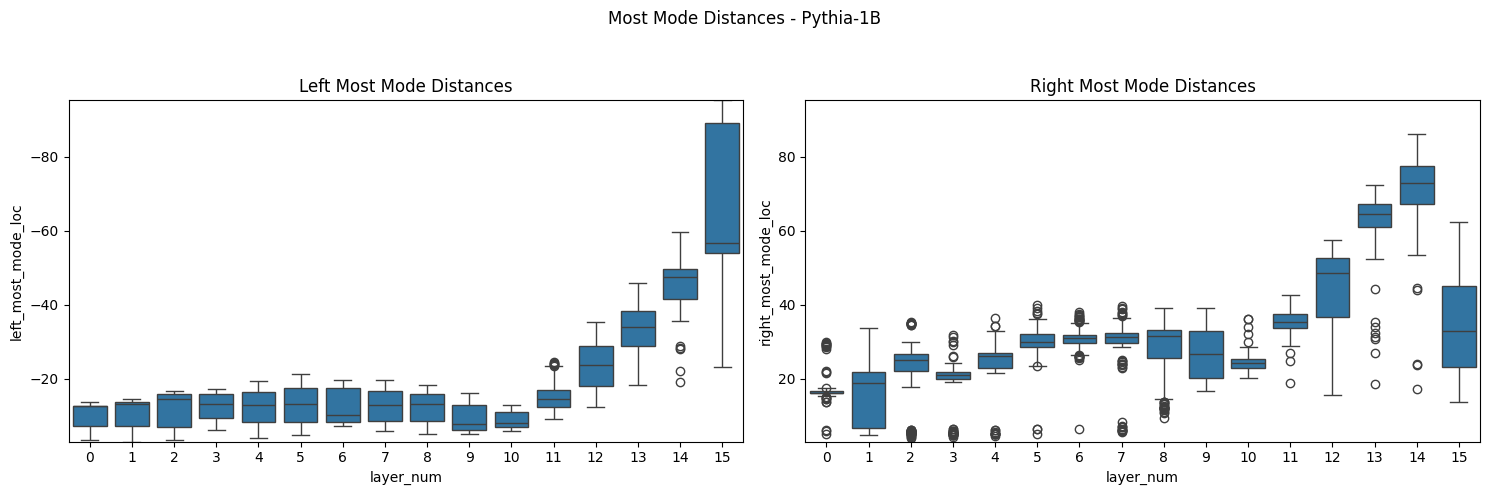

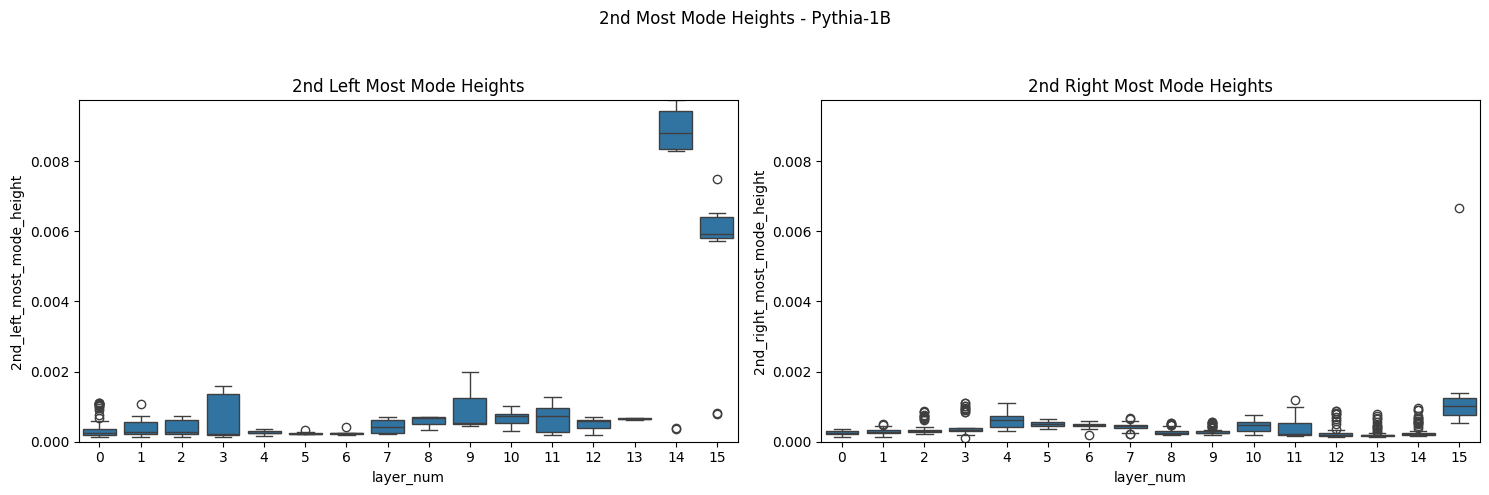

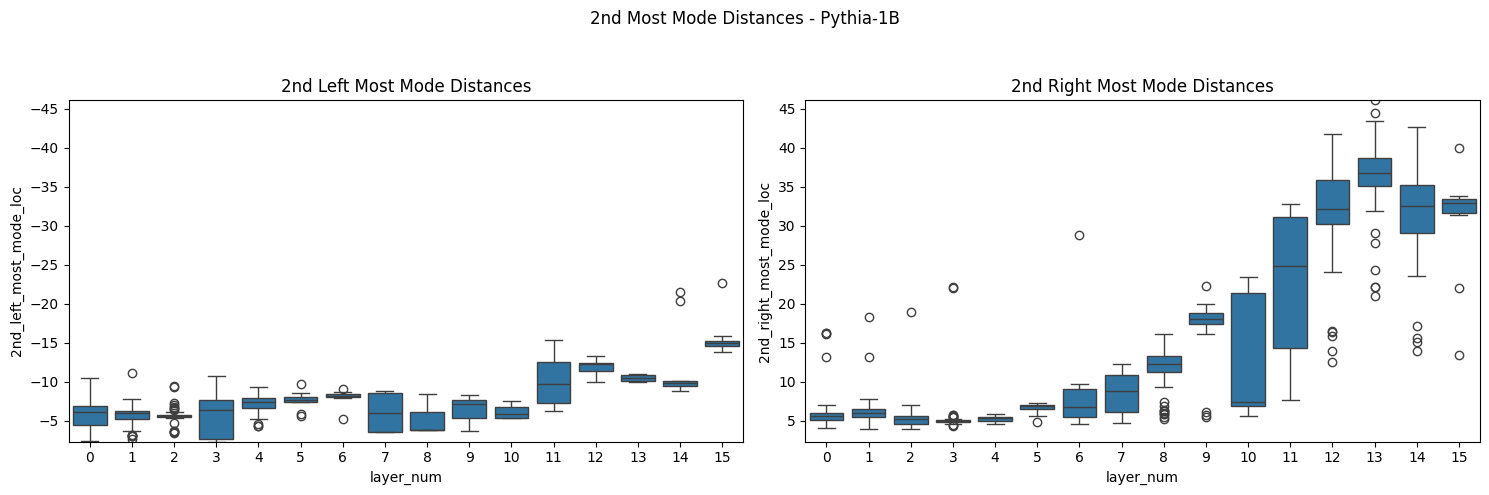

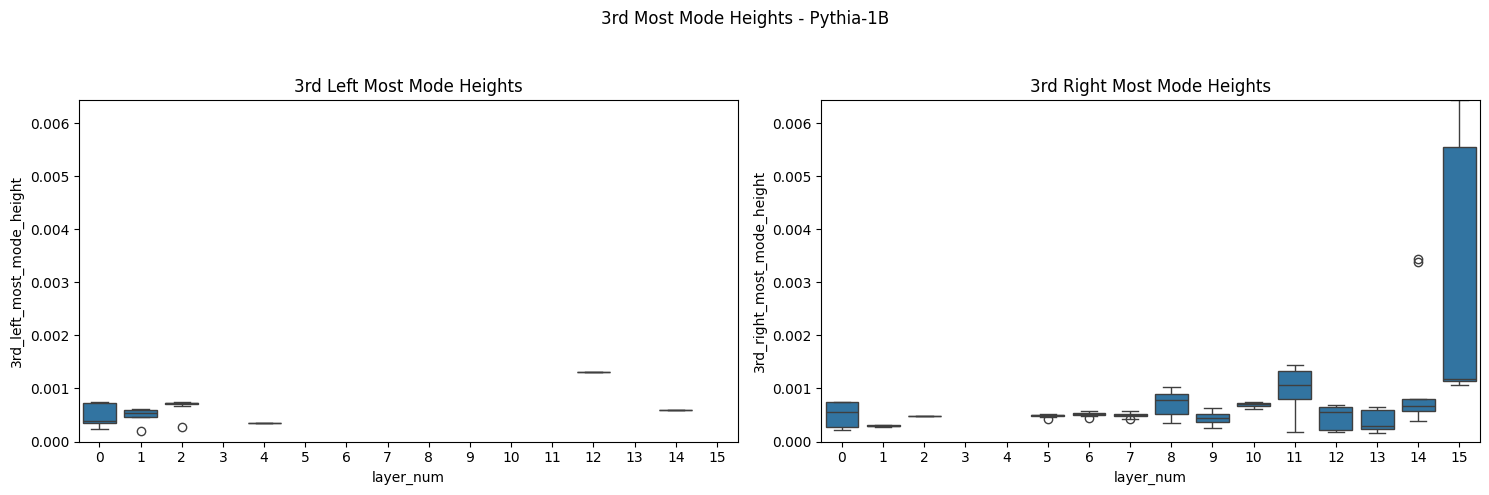

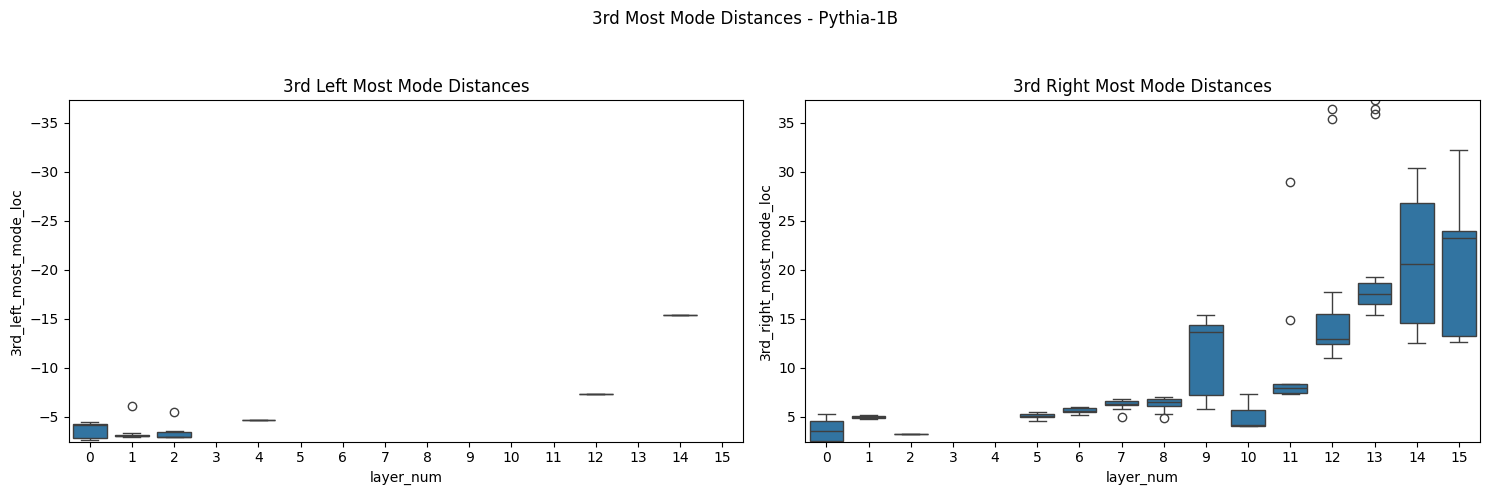

In [51]:
analyze_modes(dfs, df_names)


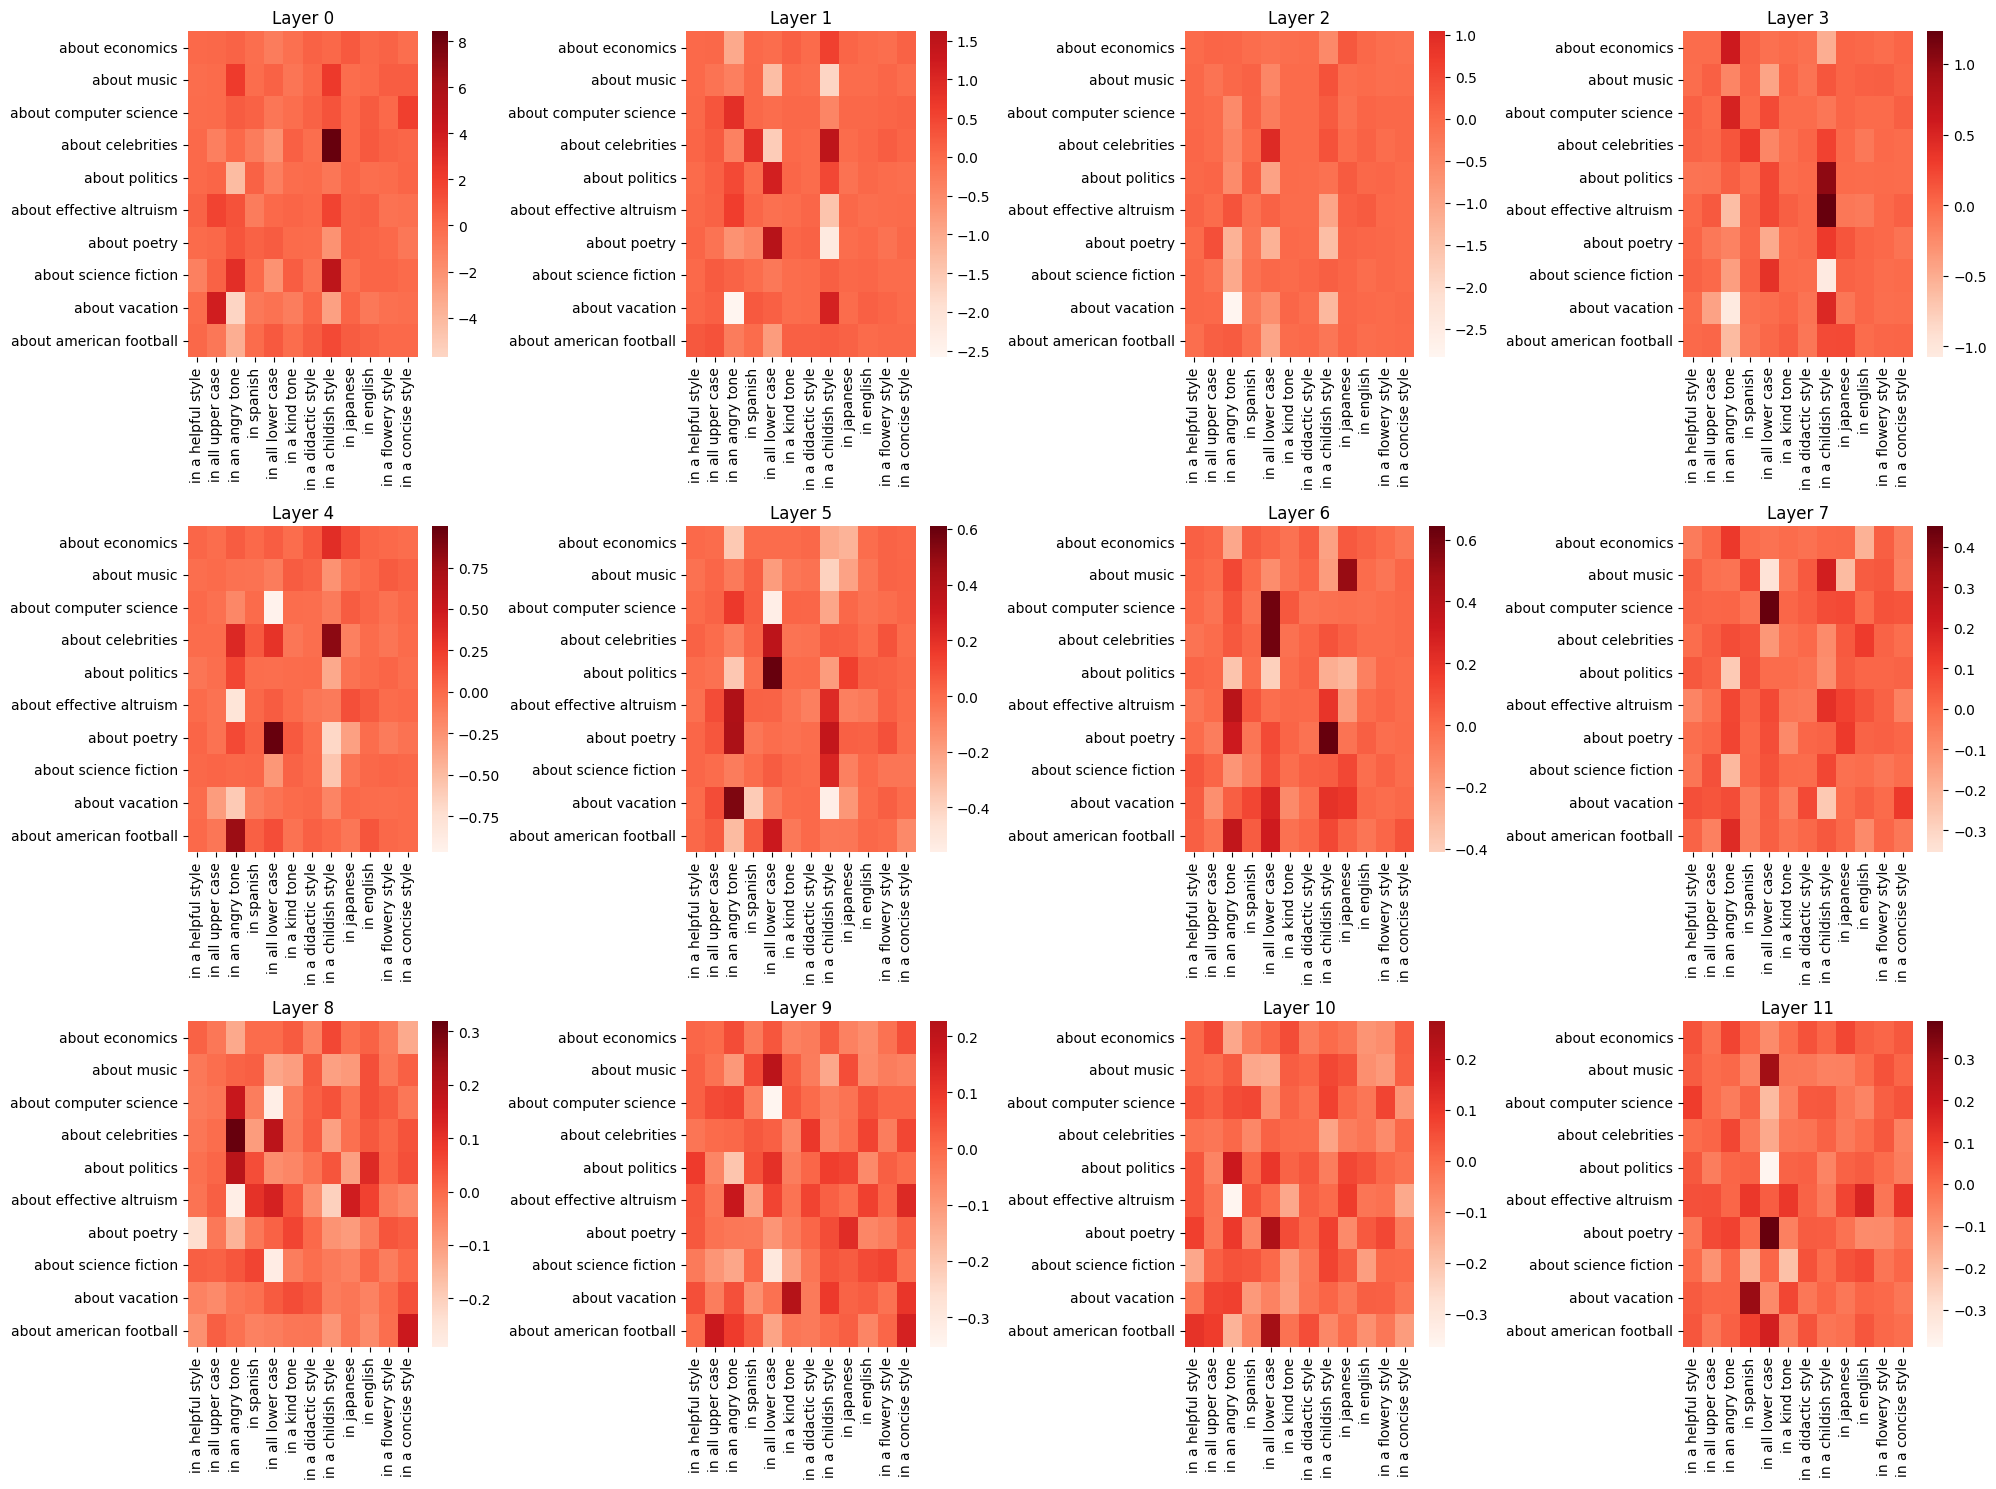

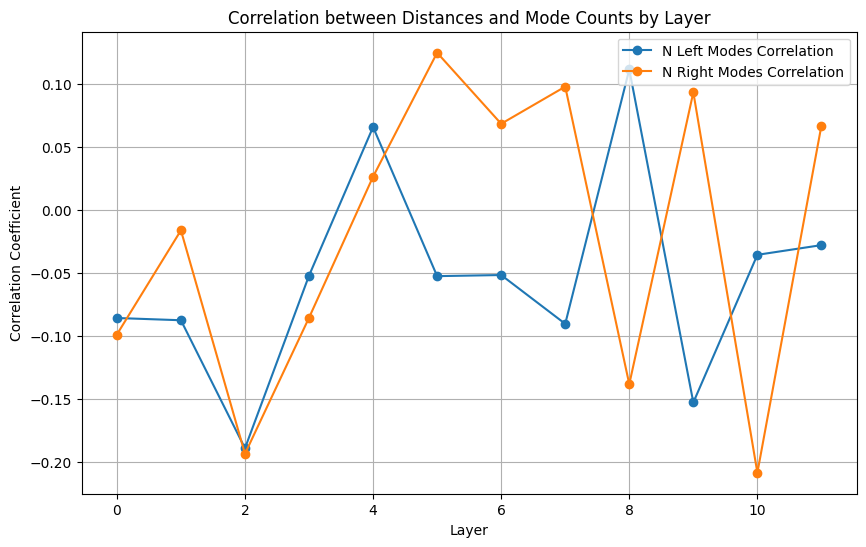

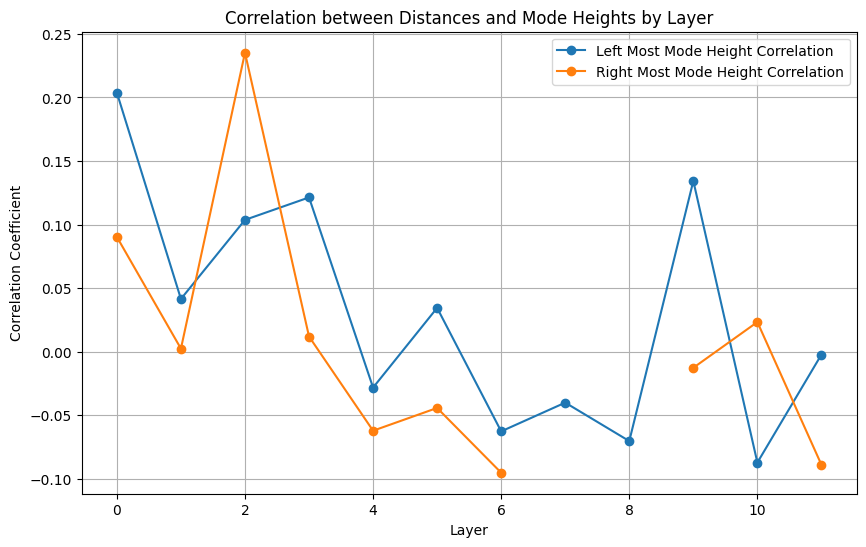

mode_matrix_left = attribute                 in a childish style  in a concise style  \
subject                                                             
about american football            -23.749335          -23.600933   
about celebrities                  -24.804663          -24.194481   
about computer science             -24.410847          -23.860889   
about economics                    -24.912853          -24.261917   
about effective altruism           -24.462414          -25.155658   
about music                        -24.044438          -23.577383   
about poetry                       -24.025940          -23.480519   
about politics                     -24.936762          -24.170300   
about science fiction              -24.384743          -23.775046   
about vacation                     -23.499930          -23.568020   

attribute                 in a didactic style  in a flowery style  \
subject                                                             
about american

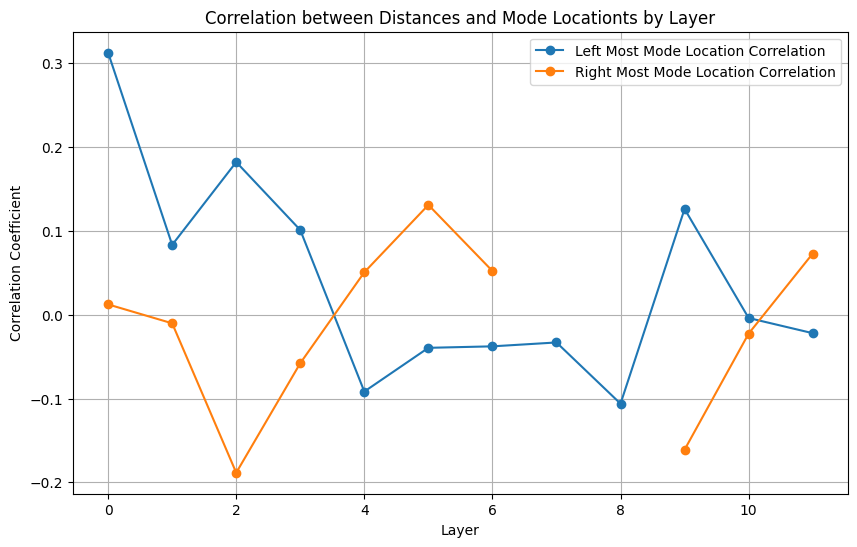


Correlations between distances and mode counts:

Left Modes Count
Layer 0: -0.086
Layer 1: -0.088
Layer 2: -0.189
Layer 3: -0.052
Layer 4: 0.066
Layer 5: -0.053
Layer 6: -0.052
Layer 7: -0.090
Layer 8: 0.111
Layer 9: -0.153
Layer 10: -0.036
Layer 11: -0.028

Right Modes Count
Layer 0: -0.099
Layer 1: -0.016
Layer 2: -0.193
Layer 3: -0.086
Layer 4: 0.026
Layer 5: 0.124
Layer 6: 0.068
Layer 7: 0.098
Layer 8: -0.138
Layer 9: 0.093
Layer 10: -0.208
Layer 11: 0.067

Correlations between distances and mode counts:

Left Modes Count
Layer 0: 0.204
Layer 1: 0.041
Layer 2: 0.104
Layer 3: 0.121
Layer 4: -0.028
Layer 5: 0.034
Layer 6: -0.063
Layer 7: -0.040
Layer 8: -0.070
Layer 9: 0.134
Layer 10: -0.087
Layer 11: -0.002

Right Modes Count
Layer 0: 0.090
Layer 1: 0.002
Layer 2: 0.235
Layer 3: 0.012
Layer 4: -0.062
Layer 5: -0.044
Layer 6: -0.095
Layer 7: nan
Layer 8: nan
Layer 9: -0.013
Layer 10: 0.023
Layer 11: -0.089


In [64]:
analyze_with_distances_grid(gpt2s, cc_heat)


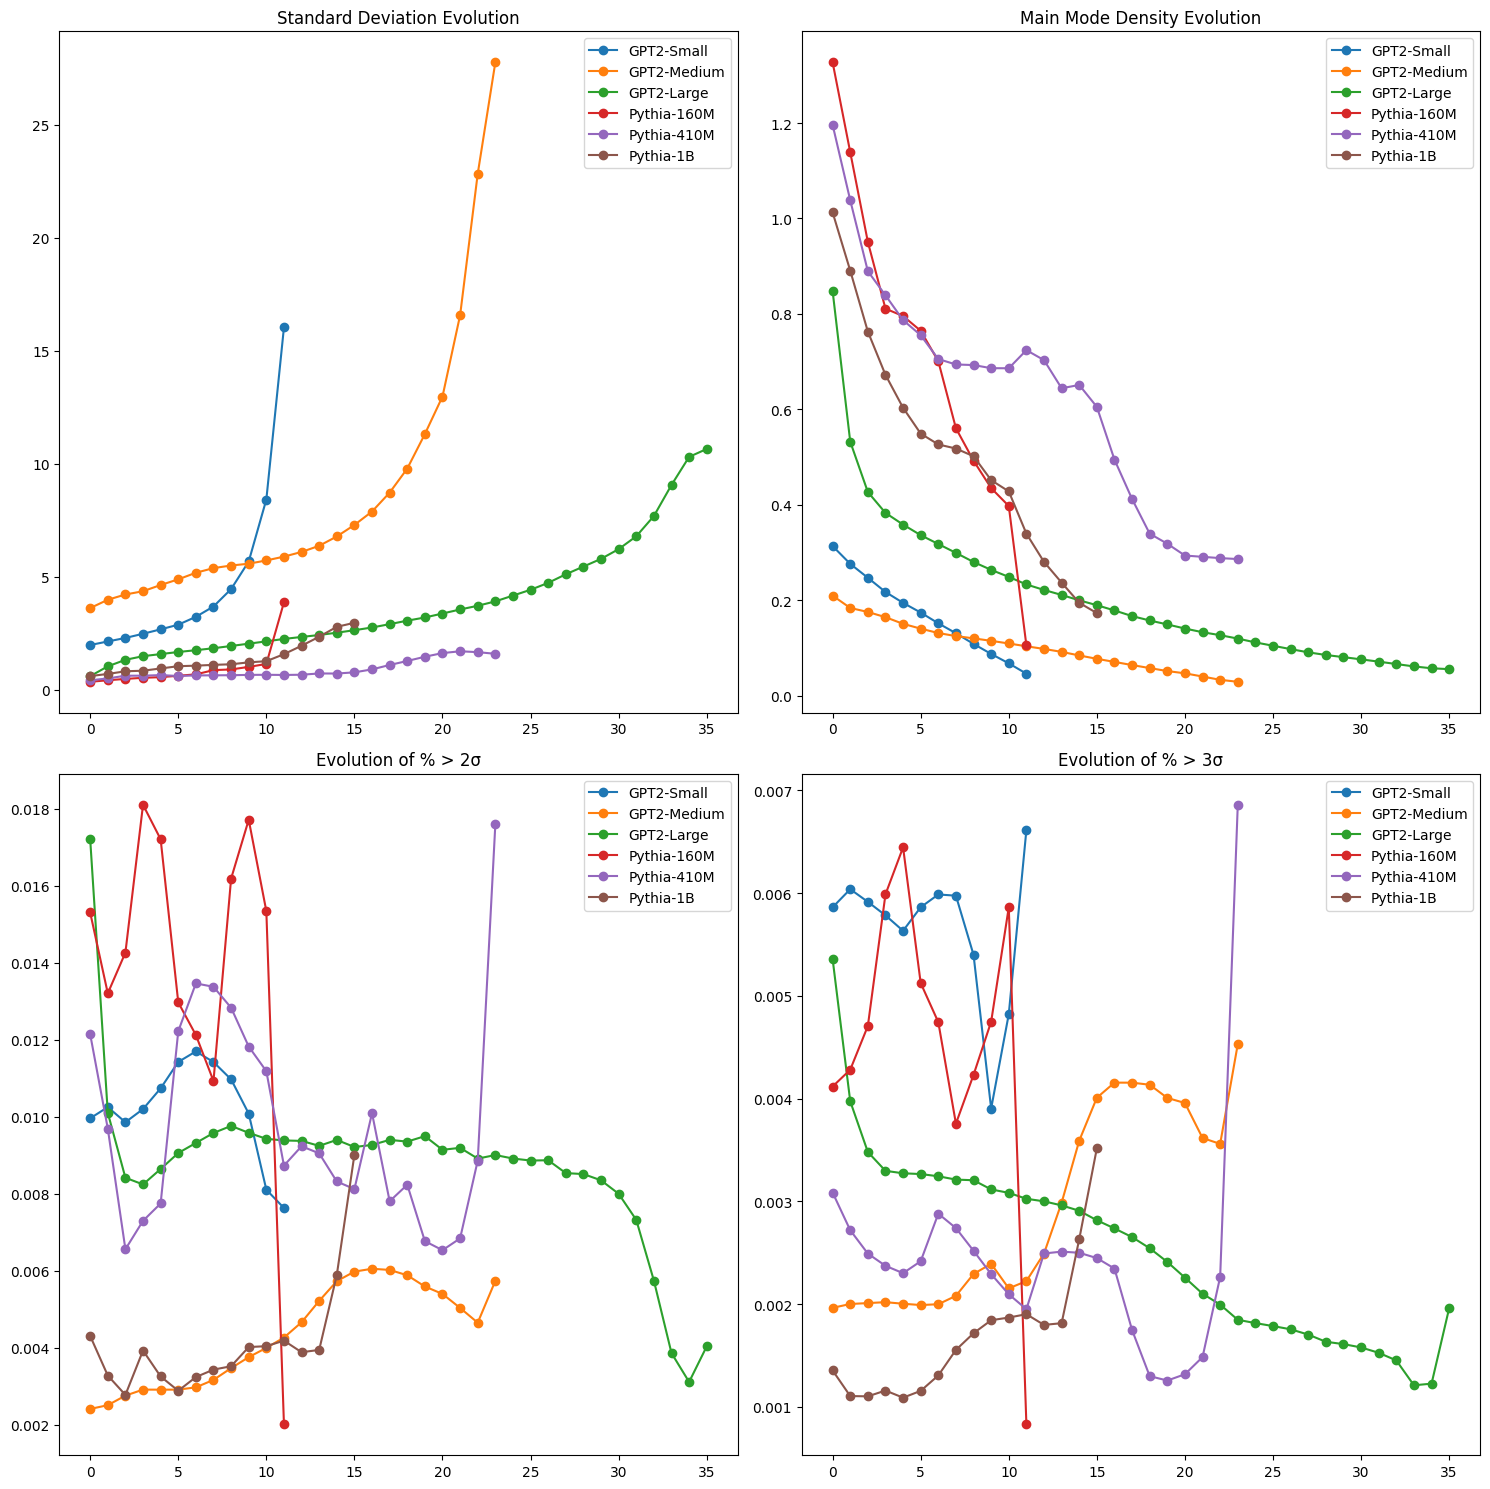

In [83]:
analyze_layer_evolution(dfs, df_names)
